In [1]:
import torch
import numpy

import h5py
import matplotlib.pyplot as plt

In [2]:
import math as mt

In [4]:
# def normalized_rmse(predictions, true_values):
#   """
#   Calculates the Normalized Root Mean Squared Error (nRMSE).

#   Args:
#     predictions: A array containing the predicted values.
#     true_values: A array containing the true values.

#   Returns:
#     The normalized root mean squared error.
#   """
#   #print(predictions.shape, true_values.shape)

#   rmse = torch.sqrt(torch.sum((predictions - true_values) ** 2 ) )

#   nrmse = rmse /   torch.sqrt(torch.sum((true_values) ** 2) )    #torch.std(true_values)
#   return nrmse

In [23]:
def normalized_rmse(predictions, true_values):
  """
  Calculates the Normalized Root Mean Squared Error (nRMSE).

  Args:
    predictions: A array containing the predicted values.
    true_values: A array containing the true values.

  Returns:
    The normalized root mean squared error.
  """
  #print(predictions.shape, true_values.shape)

  rmse = torch.sqrt(torch.mean((predictions - true_values) ** 2, dim = 1 ) )

  nrmse = rmse /   torch.sqrt(torch.mean((true_values) ** 2, dim = 1) )    #torch.std(true_values)
  #return torch.mean(nrmse)
  return nrmse

In [101]:
def metric_func(
    pred, target, if_mean=True, Lx=1.0, Ly=1.0, Lz=1.0, iLow=4, iHigh=12, initial_step=1
):
    """
    code for calculate metrics discussed in the Brain-storming session
    RMSE, normalized RMSE, max error, RMSE at the boundaries, conserved variables, RMSE in Fourier space, temporal sensitivity
    """
    #pred, target = pred.to(device), target.to(device)
    # (batch, nx^i..., timesteps, nc)
    # slice out `initial context` timesteps
    pred = pred[..., initial_step:, :]
    target = target[..., initial_step:, :]
    idxs = target.size()
    if len(idxs) == 4:  # 1D
        pred = pred.permute(0, 3, 1, 2)
        target = target.permute(0, 3, 1, 2)
    if len(idxs) == 5:  # 2D
        pred = pred.permute(0, 4, 1, 2, 3)
        target = target.permute(0, 4, 1, 2, 3)
    elif len(idxs) == 6:  # 3D
        pred = pred.permute(0, 5, 1, 2, 3, 4)
        target = target.permute(0, 5, 1, 2, 3, 4)
    idxs = target.size()
    nb, nc, nt = idxs[0], idxs[1], idxs[-1]

    # RMSE
    err_mean = torch.sqrt(
        torch.mean(
            (pred.view([nb, nc, -1, nt]) - target.view([nb, nc, -1, nt])) ** 2, dim=2
        )
    )
    err_RMSE = torch.mean(err_mean, axis=0)
    nrm = torch.sqrt(torch.mean(target.view([nb, nc, -1, nt]) ** 2, dim=2))
    err_nRMSE = torch.mean(err_mean / nrm, dim=0)

    err_CSV = torch.sqrt(
        torch.mean(
            (
                torch.sum(pred.view([nb, nc, -1, nt]), dim=2)
                - torch.sum(target.view([nb, nc, -1, nt]), dim=2)
            )
            ** 2,
            dim=0,
        )
    )
    if len(idxs) == 4:
        nx = idxs[2]
        err_CSV /= nx
    elif len(idxs) == 5:
        nx, ny = idxs[2:4]
        err_CSV /= nx * ny
    elif len(idxs) == 6:
        nx, ny, nz = idxs[2:5]
        err_CSV /= nx * ny * nz
    # worst case in all the data
    err_Max = torch.max(
        torch.max(
            torch.abs(pred.view([nb, nc, -1, nt]) - target.view([nb, nc, -1, nt])),
            dim=2,
        )[0],
        dim=0,
    )[0]

    if len(idxs) == 4:  # 1D
        err_BD = (pred[:, :, 0, :] - target[:, :, 0, :]) ** 2
        err_BD += (pred[:, :, -1, :] - target[:, :, -1, :]) ** 2
        err_BD = torch.mean(torch.sqrt(err_BD / 2.0), dim=0)
    elif len(idxs) == 5:  # 2D
        nx, ny = idxs[2:4]
        err_BD_x = (pred[:, :, 0, :, :] - target[:, :, 0, :, :]) ** 2
        err_BD_x += (pred[:, :, -1, :, :] - target[:, :, -1, :, :]) ** 2
        err_BD_y = (pred[:, :, :, 0, :] - target[:, :, :, 0, :]) ** 2
        err_BD_y += (pred[:, :, :, -1, :] - target[:, :, :, -1, :]) ** 2
        err_BD = (torch.sum(err_BD_x, dim=-2) + torch.sum(err_BD_y, dim=-2)) / (
            2 * nx + 2 * ny
        )
        err_BD = torch.mean(torch.sqrt(err_BD), dim=0)
    elif len(idxs) == 6:  # 3D
        nx, ny, nz = idxs[2:5]
        err_BD_x = (pred[:, :, 0, :, :] - target[:, :, 0, :, :]) ** 2
        err_BD_x += (pred[:, :, -1, :, :] - target[:, :, -1, :, :]) ** 2
        err_BD_y = (pred[:, :, :, 0, :] - target[:, :, :, 0, :]) ** 2
        err_BD_y += (pred[:, :, :, -1, :] - target[:, :, :, -1, :]) ** 2
        err_BD_z = (pred[:, :, :, :, 0] - target[:, :, :, :, 0]) ** 2
        err_BD_z += (pred[:, :, :, :, -1] - target[:, :, :, :, -1]) ** 2
        err_BD = (
            torch.sum(err_BD_x.contiguous().view([nb, -1, nt]), dim=-2)
            + torch.sum(err_BD_y.contiguous().view([nb, -1, nt]), dim=-2)
            + torch.sum(err_BD_z.contiguous().view([nb, -1, nt]), dim=-2)
        )
        err_BD = err_BD / (2 * nx * ny + 2 * ny * nz + 2 * nz * nx)
        err_BD = torch.sqrt(err_BD)

    if len(idxs) == 4:  # 1D
        nx = idxs[2]
        pred_F = torch.fft.rfft(pred, dim=2)
        target_F = torch.fft.rfft(target, dim=2)
        _err_F = (
            torch.sqrt(torch.mean(torch.abs(pred_F - target_F) ** 2, axis=0)) / nx * Lx
        )
    if len(idxs) == 5:  # 2D
        pred_F = torch.fft.fftn(pred, dim=[2, 3])
        target_F = torch.fft.fftn(target, dim=[2, 3])
        nx, ny = idxs[2:4]
        _err_F = torch.abs(pred_F - target_F) ** 2
        err_F = torch.zeros([nb, nc, min(nx // 2, ny // 2), nt])#.to(device)
        for i in range(nx // 2):
            for j in range(ny // 2):
                it = mt.floor(mt.sqrt(i**2 + j**2))
                if it > min(nx // 2, ny // 2) - 1:
                    continue
                err_F[:, :, it] += _err_F[:, :, i, j]
        _err_F = torch.sqrt(torch.mean(err_F, axis=0)) / (nx * ny) * Lx * Ly
    elif len(idxs) == 6:  # 3D
        pred_F = torch.fft.fftn(pred, dim=[2, 3, 4])
        target_F = torch.fft.fftn(target, dim=[2, 3, 4])
        nx, ny, nz = idxs[2:5]
        _err_F = torch.abs(pred_F - target_F) ** 2
        err_F = torch.zeros([nb, nc, min(nx // 2, ny // 2, nz // 2), nt])#.to(device)
        for i in range(nx // 2):
            for j in range(ny // 2):
                for k in range(nz // 2):
                    it = mt.floor(mt.sqrt(i**2 + j**2 + k**2))
                    if it > min(nx // 2, ny // 2, nz // 2) - 1:
                        continue
                    err_F[:, :, it] += _err_F[:, :, i, j, k]
        _err_F = torch.sqrt(torch.mean(err_F, axis=0)) / (nx * ny * nz) * Lx * Ly * Lz

    err_F = torch.zeros([nc, 3, nt])#.to(device)
    err_F[:, 0] += torch.mean(_err_F[:, :iLow], dim=1)  # low freq
    err_F[:, 1] += torch.mean(_err_F[:, iLow:iHigh], dim=1)  # middle freq
    err_F[:, 2] += torch.mean(_err_F[:, iHigh:], dim=1)  # high freq

    if if_mean:
        return (
            torch.mean(err_RMSE, dim=[0, -1]),
            torch.mean(err_nRMSE, dim=[0, -1]),
            torch.mean(err_CSV, dim=[0, -1]),
            torch.mean(err_Max, dim=[0, -1]),
            torch.mean(err_BD, dim=[0, -1]),
            torch.mean(err_F, dim=[0, -1]),
        )
    return err_RMSE, err_nRMSE, err_CSV, err_Max, err_BD, err_F


In [32]:
import numpy as np

In [4]:

hdf5_file = h5py.File('/nobackup/scoc/variable_autoregression/dataset/data/B1/1D_Burgers_Sols_Nu0.01_n_2000.h5', 'r')
time = hdf5_file['t-coordinate'][:]
tensor =  hdf5_file['tensor'][:]
x =  hdf5_file['x-coordinate'][:]

In [34]:
#file = "/nobackup/scoc/variable_autoregression/generate_data/takamoto_dataset/burgersEq/1D_Burgers_Sols_Nu0.01.npy"
file = "/nobackup/scoc/variable_autoregression/dataset/data/B1/1D_Burgers_Sols_Nu0.01_K1_N2_Sa2100.npy"

In [35]:
hdf5_train_file = np.load(file)
train_loaded_data = hdf5_train_file[0,:1500]

In [36]:
train_loaded_data.shape

(1500, 201, 1024)

In [ ]:
train_loaded_data.shape

In [34]:
data = np.load(file) 

# Access and use the loaded data
#print(data) 
print(data.shape) 
print(data.dtype) 

(1, 2100, 201, 1024)
float32


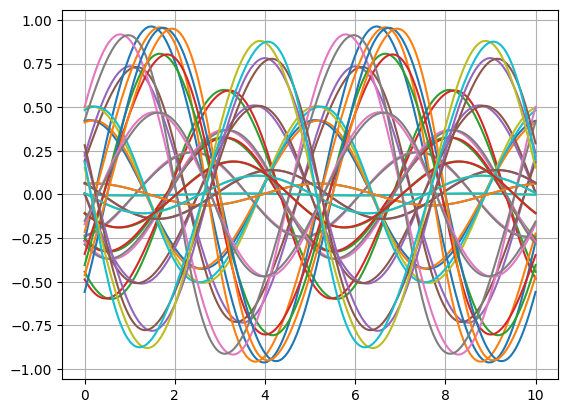

In [38]:
for i in range(100,2100,100):
    plt.plot(np.linspace(0,10,1024), data[0,i,0,:])
    plt.plot(np.linspace(0,10,1024), data[0,i,1,:])
    #plt.plot(np.linspace(0,10,1024), data[0,i,-1,:], "--")
plt.grid()

In [5]:
time = hdf5_file['t-coordinate'][:]
tensor =  hdf5_file['tensor'][:]
x =  hdf5_file['x-coordinate'][:]

In [10]:
file_loc = "/nobackup/scoc/variable_autoregression/result/B1/variable_time/B1_1/run_2/run_2_proto_1.pt"
test_var = torch.load(file_loc, map_location="cpu")
print(test_var.keys())

dict_keys(['train_cons_oto_250', 'train_cons_ro_250', 'train_var_oto_250', 'train_var_ro_250', 'test_var_oto_250', 'test_var_ro_250'])


In [131]:
file_loc = "/nobackup/scoc/variable_autoregression/result/B1/variable_time/B1_1/run_2/run_2_result.pt"
test_var = torch.load(file_loc, map_location="cpu")
print(test_var.keys())

dict_keys(['train_cons_oto_250', 'train_cons_ro_250', 'test_cons_oto_250', 'test_cons_ro_250', 'valid_cons_oto_250', 'valid_cons_ro_250', 'train_var_oto_250', 'train_var_ro_250', 'test_var_oto_250', 'test_var_ro_250', 'valid_var_oto_250', 'valid_var_ro_250'])


In [11]:
torch.randint(5, (5,2)) + 1

tensor([[4, 1],
        [1, 5],
        [5, 4],
        [3, 5],
        [4, 2]])

In [ ]:
torch.cat((torch.arange(0,65,2), torch.arange(68,201,2)), )

In [93]:
file_loc = "/nobackup/scoc/variable_autoregression/result/B1/variable_time/B1_1_FNO_attention/run_6/run_6_result_prior_dt2.pt"
test_var_prior_2 = torch.load(file_loc, map_location="cpu")
print(test_var_prior_2.keys())

dict_keys(['train_cons_oto_250', 'train_cons_ro_250', 'test_cons_oto_250', 'test_cons_ro_250', 'valid_cons_oto_250', 'valid_cons_ro_250', 'train_var_oto_250', 'train_var_ro_250', 'test_var_oto_250', 'test_var_ro_250', 'valid_var_oto_250', 'valid_var_ro_250'])


In [94]:
timestep_2 = torch.cat(( torch.arange(10), torch.arange(11,201,2)))

In [68]:
file_loc = "/nobackup/scoc/variable_autoregression/result/B1/variable_time/B1_1_FNO_attention/run_6/run_6_result_prior_dt1_3.pt"
test_var_prior_1_3 = torch.load(file_loc, map_location="cpu")
print(test_var_prior_1_3.keys())

dict_keys(['train_cons_oto_250', 'train_cons_ro_250', 'test_cons_oto_250', 'test_cons_ro_250', 'valid_cons_oto_250', 'valid_cons_ro_250', 'train_var_oto_250', 'train_var_ro_250', 'test_var_oto_250', 'test_var_ro_250', 'valid_var_oto_250', 'valid_var_ro_250'])


In [67]:
timestep_1_3 = torch.cat((torch.arange(10), torch.arange(10,50,1), torch.arange(53,201,3)))

In [66]:
file_loc = "/nobackup/scoc/variable_autoregression/result/B1/variable_time/B1_1_FNO_attention/run_6/run_6_result_prior_dt3_1.pt"
test_var_prior_3_1 = torch.load(file_loc, map_location="cpu")
print(test_var_prior_3_1.keys())

dict_keys(['train_cons_oto_250', 'train_cons_ro_250', 'test_cons_oto_250', 'test_cons_ro_250', 'valid_cons_oto_250', 'valid_cons_ro_250', 'train_var_oto_250', 'train_var_ro_250', 'test_var_oto_250', 'test_var_ro_250', 'valid_var_oto_250', 'valid_var_ro_250'])


In [65]:
timestep_3_1 = torch.cat(( torch.arange(10), torch.arange(10,160,3), torch.arange(161,201,1)))

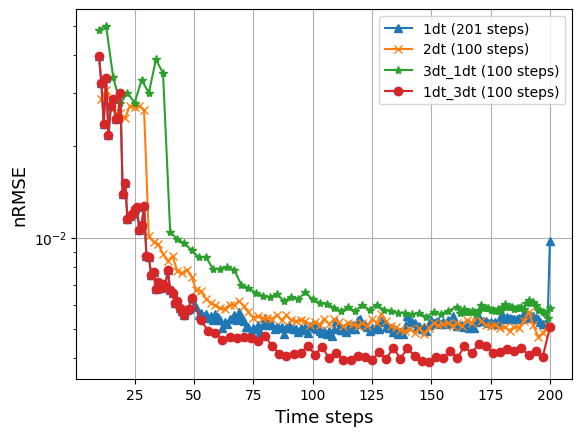

In [99]:
plt.plot(torch.arange(0,201,1)[10:], torch.mean( normalized_rmse(test_var_prior_3_1["test_cons_ro_250"][1], test_var_prior_3_1["test_cons_ro_250"][2]), dim=0 ), "^-", label="1dt (201 steps)")
plt.plot(timestep_2[10:], torch.mean( normalized_rmse(test_var_prior_2["test_var_ro_250"][1], test_var_prior_2["test_var_ro_250"][2]), dim=0 ), "x-", label="2dt (100 steps)")
plt.plot(timestep_3_1[10:], torch.mean( normalized_rmse(test_var_prior_3_1["test_var_ro_250"][1], test_var_prior_3_1["test_var_ro_250"][2]), dim=0 ), "*-", label="3dt_1dt (100 steps)")
plt.plot(timestep_1_3[10:], torch.mean( normalized_rmse(test_var_prior_1_3["test_var_ro_250"][1], test_var_prior_1_3["test_var_ro_250"][2]), dim=0 ), "o-", label="1dt_3dt (100 steps)")
plt.yscale("log")
#plt.xscale("log")
plt.legend()
plt.xlabel("Time steps", fontsize="13")
plt.ylabel("nRMSE", fontsize="13")
plt.grid()

## E1

In [60]:
#file_loc = "/nobackup/scoc/variable_autoregression/result/B1/constant_time/dt_1_ms_1_horizon_1/run_1/run_1_result.pt"
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/FNO/baseline/run_5/run_5.pt"
test_var_prior_3_1 = torch.load(file_loc, map_location="cpu")
print(test_var_prior_3_1.keys())

dict_keys(['train_cons_oto_250', 'train_cons_ro_250', 'cons_oto_250', 'cons_ro_250'])


In [62]:
# prediction_B1_var_prior_3_1 = test_var_prior_3_1["test_cons_ro_250"][1]
# actual_B1_var_prior_3_1 = test_var_prior_3_1["test_cons_ro_250"][2]

prediction_B1_var_prior_3_1 = test_var_prior_3_1["cons_ro_250"][1]
actual_B1_var_prior_3_1 = test_var_prior_3_1["cons_ro_250"][2]

In [65]:
prediction_B1_var_prior_3_1.shape

torch.Size([128, 100, 249])

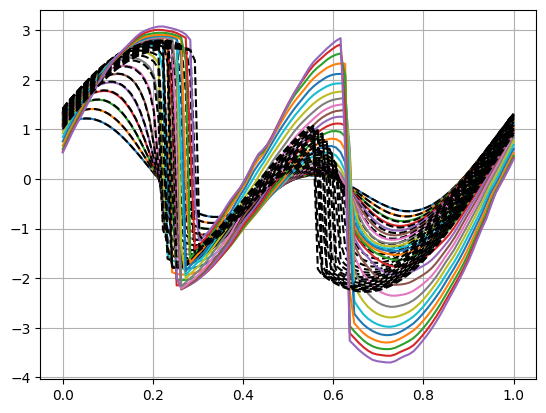

In [72]:
t = [ii for ii in range(0,250,10)]
#t = [0]
samp = 10
for i in t:
    #plt.plot(torch.linspace(0,1,256), prediction_B1_cons[samp,:,-1], "b")
    plt.plot(torch.linspace(0,1,100), prediction_B1_var_prior_3_1[samp,:,i],  )
    #plt.plot(torch.linspace(0,1,256), train_prediction_B1[samp,:,i])
    #plt.plot(torch.linspace(0,1,256), train_actual_B1[samp,:,i], "k--")
    plt.plot(torch.linspace(0,1,100), actual_B1_var_prior_3_1[samp,:,i], "k--")

#plt.legend(t)
plt.grid()

In [3]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/variable_time/FNO_attention_1/run_2/run_2_result_prior_dt3_1.pt"
test_var_prior_3_1 = torch.load(file_loc, map_location="cpu")
print(test_var_prior_3_1.keys())

dict_keys(['train_cons_oto_250', 'train_cons_ro_250', 'test_cons_oto_250', 'test_cons_ro_250', 'valid_cons_oto_250', 'valid_cons_ro_250', 'train_var_oto_250', 'train_var_ro_250', 'test_var_oto_250', 'test_var_ro_250', 'valid_var_oto_250', 'valid_var_ro_250'])


In [4]:
prediction_B1_var_prior_3_1 = test_var_prior_3_1["test_var_ro_250"][1]
actual_B1_var_prior_3_1 = test_var_prior_3_1["test_var_ro_250"][2]

print(prediction_B1_var_prior_3_1.shape, actual_B1_var_prior_3_1.shape )

torch.Size([128, 200, 120]) torch.Size([128, 200, 120])


In [36]:
test_var_prior_3_1["test_var_ro_250"][-1][0]

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  13,  16,  19,
         22,  25,  28,  31,  34,  37,  40,  43,  46,  49,  52,  55,  58,  61,
         64,  67,  70,  73,  76,  79,  82,  85,  88,  91,  94,  97, 100, 103,
        106, 109, 112, 115, 118, 121, 124, 127, 130, 133, 136, 139, 142, 145,
        148, 151, 154, 157, 160, 163, 166, 169, 172, 175, 178, 181, 184, 187,
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
        204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
        218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
        232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
        246, 247, 248, 249])

In [5]:
torch.mean(normalized_rmse(prediction_B1_var_prior_3_1, actual_B1_var_prior_3_1))

tensor(0.2203)

In [6]:
torch.mean(normalized_rmse(prediction_B1_var_prior_3_1[...,-1:], actual_B1_var_prior_3_1[...,-1:]))

tensor(0.4018)

In [7]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/variable_time/FNO_attention_1/run_2/run_2_result_prior_dt1_3.pt"
test_var_prior_1_3 = torch.load(file_loc, map_location="cpu")
print(test_var_prior_1_3.keys())

dict_keys(['train_cons_oto_250', 'train_cons_ro_250', 'test_cons_oto_250', 'test_cons_ro_250', 'valid_cons_oto_250', 'valid_cons_ro_250', 'train_var_oto_250', 'train_var_ro_250', 'test_var_oto_250', 'test_var_ro_250', 'valid_var_oto_250', 'valid_var_ro_250'])


In [8]:
prediction_B1_var_prior_1_3 = test_var_prior_1_3["test_var_ro_250"][1]
actual_B1_var_prior_1_3 = test_var_prior_1_3["test_var_ro_250"][2]

print(prediction_B1_var_prior_1_3.shape, actual_B1_var_prior_1_3.shape )

torch.Size([128, 200, 120]) torch.Size([128, 200, 120])


In [9]:
torch.mean(normalized_rmse(prediction_B1_var_prior_1_3, actual_B1_var_prior_1_3))

tensor(0.1151)

In [10]:
torch.mean(normalized_rmse(prediction_B1_var_prior_1_3[...,-1:], actual_B1_var_prior_1_3[...,-1:]))

tensor(0.4211)

In [12]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/variable_time/FNO_attention_1/run_2/run_2_result_prior_dt2.pt"
test_var_prior_2 = torch.load(file_loc, map_location="cpu")
print(test_var_prior_2.keys())

dict_keys(['train_cons_oto_250', 'train_cons_ro_250', 'test_cons_oto_250', 'test_cons_ro_250', 'valid_cons_oto_250', 'valid_cons_ro_250', 'train_var_oto_250', 'train_var_ro_250', 'test_var_oto_250', 'test_var_ro_250', 'valid_var_oto_250', 'valid_var_ro_250'])


In [13]:
prediction_B1_var_prior_2 = test_var_prior_2["test_var_ro_250"][1]
actual_B1_var_prior_2 = test_var_prior_2["test_var_ro_250"][2]

print(prediction_B1_var_prior_2.shape, actual_B1_var_prior_2.shape )

torch.Size([128, 200, 120]) torch.Size([128, 200, 120])


In [14]:
torch.mean(normalized_rmse(prediction_B1_var_prior_2, actual_B1_var_prior_2))

tensor(0.1634)

In [15]:
torch.mean(normalized_rmse(prediction_B1_var_prior_1_3[...,-1:], actual_B1_var_prior_1_3[...,-1:]))

tensor(0.4211)

In [ ]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/variable_time/FNO_attention_1/run_2/run_2_result_prior_dt2.pt"
test_var_prior_2 = torch.load(file_loc, map_location="cpu")
print(test_var_prior_2.keys())

In [32]:
prediction_B1_cons = test_var_prior_3_1["test_cons_ro_250"][1]
actual_B1_cons = test_var_prior_3_1["test_cons_ro_250"][2]

print(prediction_B1_cons.shape, actual_B1_cons.shape )

torch.Size([128, 200, 240]) torch.Size([128, 200, 240])


In [33]:
torch.mean(normalized_rmse(prediction_B1_cons, actual_B1_cons))

tensor(0.1762)

In [34]:
torch.mean(normalized_rmse(prediction_B1_cons[...,-1:], actual_B1_cons[...,:-1:]))

tensor(0.9516)

In [35]:
timestep_2 = torch.cat(( torch.arange(10), torch.arange(11,250,2)))
timestep_3_1 = torch.cat(( torch.arange(10), torch.arange(10,190,3), torch.arange(190,250,1)))
timestep_1_3 = torch.cat(( torch.arange(10), torch.arange(10,69,1), torch.arange(69,250,3)))

/tmp/ipykernel_85820/2748578722.py:8: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,0.1])


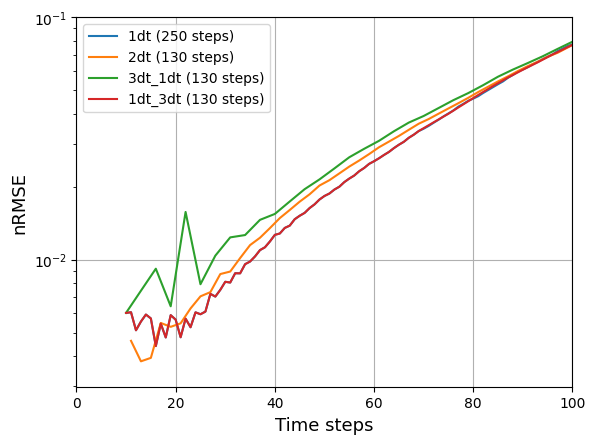

In [44]:
plt.plot(torch.arange(0,250,1)[10:], torch.mean( normalized_rmse(test_var_prior_3_1["test_cons_ro_250"][1], test_var_prior_3_1["test_cons_ro_250"][2]), dim=0 ), label="1dt (250 steps)")
plt.plot(timestep_2[10:], torch.mean( normalized_rmse(test_var_prior_2["test_var_ro_250"][1], test_var_prior_2["test_var_ro_250"][2]), dim=0 ), label="2dt (130 steps)")
plt.plot(timestep_3_1[10:], torch.mean( normalized_rmse(test_var_prior_3_1["test_var_ro_250"][1], test_var_prior_3_1["test_var_ro_250"][2]), dim=0 ), label="3dt_1dt (130 steps)")
plt.plot(timestep_1_3[10:], torch.mean( normalized_rmse(test_var_prior_1_3["test_var_ro_250"][1], test_var_prior_1_3["test_var_ro_250"][2]), dim=0 ), label="1dt_3dt (130 steps)")
plt.yscale("log")
#plt.xscale("log")
plt.xlim([0,100])
plt.ylim([0,0.1])
plt.legend()
plt.xlabel("Time steps", fontsize="13")
plt.ylabel("nRMSE", fontsize="13")
plt.grid()

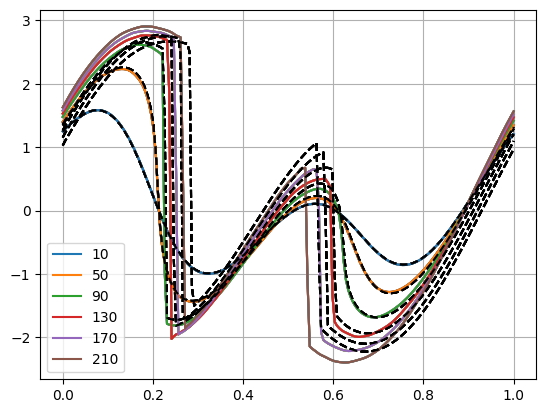

In [60]:
t = [ii for ii in range(10,250,40)]
#t = [0]
samp = 10
for i in t:
    #plt.plot(torch.linspace(0,1,256), prediction_B1_cons[samp,:,-1], "b")
    plt.plot(torch.linspace(0,1,200), test_var_prior_3_1["test_cons_ro_250"][1][samp,:,t],  )
    #plt.plot(torch.linspace(0,1,256), train_prediction_B1[samp,:,i])
    #plt.plot(torch.linspace(0,1,256), train_actual_B1[samp,:,i], "k--")
    plt.plot(torch.linspace(0,1,200), test_var_prior_3_1["test_cons_ro_250"][2][samp,:,t], "k--")

plt.legend(t)
plt.grid()

In [4]:
prediction_B1_var = test_var["train_var_ro_250"][1]
actual_B1_var = test_var["train_var_ro_250"][2]

print(prediction_B1_var.shape, actual_B1_var.shape )

NameError: name 'test_var' is not defined

In [128]:
prediction_B1_var[...,190:].shape

torch.Size([32, 256, 1])

tensor(0.0164)

In [116]:
prediction_B1_var_prior = test_var_prior["train_var_ro_250"][1]
actual_B1_var_prior = test_var_prior["train_var_ro_250"][2]

print(prediction_B1_var_prior.shape, actual_B1_var_prior.shape )

torch.Size([32, 256, 90]) torch.Size([32, 256, 90])


tensor([[  0,   2,   4,  ..., 196, 198, 200],
        [  0,   2,   4,  ..., 196, 198, 200],
        [  0,   2,   4,  ..., 196, 198, 200],
        ...,
        [  0,   2,   4,  ..., 196, 198, 200],
        [  0,   2,   4,  ..., 196, 198, 200],
        [  0,   2,   4,  ..., 196, 198, 200]])

In [ ]:
torch.sort(torch.randint(100))

In [136]:
a = torch.cat(( torch.arange(10), torch.arange(11,250,2)))
print(len(a))
print(a)

130
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  11,  13,  15,  17,
         19,  21,  23,  25,  27,  29,  31,  33,  35,  37,  39,  41,  43,  45,
         47,  49,  51,  53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,
         75,  77,  79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101,
        103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129,
        131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157,
        159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185,
        187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207, 209, 211, 213,
        215, 217, 219, 221, 223, 225, 227, 229, 231, 233, 235, 237, 239, 241,
        243, 245, 247, 249])


In [134]:
a = torch.cat(( torch.arange(10), torch.arange(10,69,1), torch.arange(69,251,3)))
print(len(a))
print(a)

130
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         72,  75,  78,  81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111,
        114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153,
        156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195,
        198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234, 237,
        240, 243, 246, 249])


In [131]:
a = torch.cat(( torch.arange(10), torch.arange(10,190,3), torch.arange(190,250,1)))
print(len(a))
print(a)

130
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  13,  16,  19,
         22,  25,  28,  31,  34,  37,  40,  43,  46,  49,  52,  55,  58,  61,
         64,  67,  70,  73,  76,  79,  82,  85,  88,  91,  94,  97, 100, 103,
        106, 109, 112, 115, 118, 121, 124, 127, 130, 133, 136, 139, 142, 145,
        148, 151, 154, 157, 160, 163, 166, 169, 172, 175, 178, 181, 184, 187,
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
        204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
        218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
        232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
        246, 247, 248, 249])


In [88]:
a = torch.cat(( torch.arange(10), torch.arange(11,201,2)))
print(len(a))
print(a)

105
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  11,  13,  15,  17,
         19,  21,  23,  25,  27,  29,  31,  33,  35,  37,  39,  41,  43,  45,
         47,  49,  51,  53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,
         75,  77,  79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101,
        103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129,
        131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157,
        159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185,
        187, 189, 191, 193, 195, 197, 199])


In [54]:
a = torch.cat(( torch.arange(10), torch.arange(10,160,3), torch.arange(161,201,1)))
print(len(a))
print(a)

100
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  13,  16,  19,
         22,  25,  28,  31,  34,  37,  40,  43,  46,  49,  52,  55,  58,  61,
         64,  67,  70,  73,  76,  79,  82,  85,  88,  91,  94,  97, 100, 103,
        106, 109, 112, 115, 118, 121, 124, 127, 130, 133, 136, 139, 142, 145,
        148, 151, 154, 157, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
        185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
        199, 200])


In [52]:
a = torch.cat(( torch.arange(10), torch.arange(10,50,1), torch.arange(53,201,3)))
print(len(a))
print(a)

100
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  53,  56,  59,  62,  65,  68,
         71,  74,  77,  80,  83,  86,  89,  92,  95,  98, 101, 104, 107, 110,
        113, 116, 119, 122, 125, 128, 131, 134, 137, 140, 143, 146, 149, 152,
        155, 158, 161, 164, 167, 170, 173, 176, 179, 182, 185, 188, 191, 194,
        197, 200])


In [157]:
a = torch.cat((torch.arange(0,150,3),          torch.arange(151,201,1)))
print(len(a))
print(a)

100
tensor([  0,   3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,  39,
         42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,  78,  81,
         84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114, 117, 120, 123,
        126, 129, 132, 135, 138, 141, 144, 147, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
        185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
        199, 200])


In [88]:
a.unsqueeze(0).repeat(10,1)

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  67,  71,  75,  79,
          83,  87,  91,  95,  99, 103, 107, 111, 115, 119, 123, 127, 131, 135,
         139, 143, 147, 151, 155, 159, 163, 167, 171, 175, 179, 183, 187, 191,
         195, 199],
        [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  67,  71,  75,  79,
          83,  87,  91,  95,  99

In [70]:
normalized_rmse(prediction_B1_var, actual_B1_var)

tensor(0.0247)

In [92]:
normalized_rmse(prediction_B1_var_prior, actual_B1_var_prior)

tensor(0.0325)

In [118]:
normalized_rmse(prediction_B1_var_prior, actual_B1_var_prior)

tensor(0.0134)

In [71]:
normalized_rmse(prediction_B1_var[...,-1:], actual_B1_var[...,:-1:])

tensor(0.4894)

In [93]:
normalized_rmse(prediction_B1_var_prior[...,-1:], actual_B1_var_prior[...,:-1:])

tensor(0.6496)

In [119]:
normalized_rmse(prediction_B1_var_prior[...,-1:], actual_B1_var_prior[...,:-1:])

tensor(0.4876)

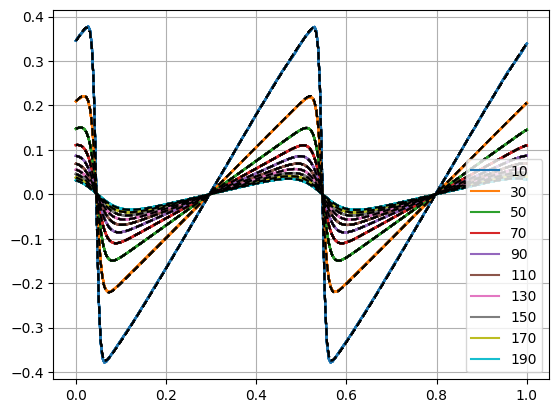

In [122]:
t = [ii for ii in range(10,201,20)]
#t = [0]
samp = 10
for i in t:
    #plt.plot(torch.linspace(0,1,256), prediction_B1_cons[samp,:,-1], "b")
    plt.plot(torch.linspace(0,1,256), prediction_B1_var_prior[samp,:,t],  )
    #plt.plot(torch.linspace(0,1,256), train_prediction_B1[samp,:,i])
    #plt.plot(torch.linspace(0,1,256), train_actual_B1[samp,:,i], "k--")
    plt.plot(torch.linspace(0,1,256), actual_B1_var_prior[samp,:,t], "k--")

plt.legend(t)
plt.grid()

## rest

In [49]:
file_loc = "/nobackup/scoc/variable_autoregression/result/B1/variable_time/B1_1_FNO_attention/run_5/run_5_result.pt"
test = torch.load(file_loc, map_location="cpu")
print(test.keys())

dict_keys(['train_cons_oto_250', 'train_cons_ro_250', 'test_cons_oto_250', 'test_cons_ro_250', 'valid_cons_oto_250', 'valid_cons_ro_250', 'train_var_oto_250', 'train_var_ro_250', 'test_var_oto_250', 'test_var_ro_250', 'valid_var_oto_250', 'valid_var_ro_250'])


In [4]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/variable_time/FNO_attention_1/run_1/run_1_result.pt"
test = torch.load(file_loc, map_location="cpu")
print(test.keys())

dict_keys(['train_cons_oto_250', 'train_cons_ro_250', 'test_cons_oto_250', 'test_cons_ro_250', 'valid_cons_oto_250', 'valid_cons_ro_250', 'train_var_oto_250', 'train_var_ro_250', 'test_var_oto_250', 'test_var_ro_250', 'valid_var_oto_250', 'valid_var_ro_250'])


In [31]:
file_loc = "/nobackup/scoc/variable_autoregression/result/B1/variable_time/B1_1/run_5/run_5_result.pt"
test_1 = torch.load(file_loc, map_location="cpu")
print(test_1.keys())


dict_keys(['train_cons_oto_250', 'train_cons_ro_250', 'test_cons_oto_250', 'test_cons_ro_250', 'valid_cons_oto_250', 'valid_cons_ro_250', 'train_var_oto_250', 'train_var_ro_250', 'test_var_oto_250', 'test_var_ro_250', 'valid_var_oto_250', 'valid_var_ro_250'])


In [21]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/variable_time/FNO_concat_1/run_1_1/run_1_1_result.pt"
test_1 = torch.load(file_loc, map_location="cpu")
print(test_1.keys())

dict_keys(['train_cons_oto_250', 'train_cons_ro_250', 'test_cons_oto_250', 'test_cons_ro_250', 'valid_cons_oto_250', 'valid_cons_ro_250', 'train_var_oto_250', 'train_var_ro_250', 'test_var_oto_250', 'test_var_ro_250', 'valid_var_oto_250', 'valid_var_ro_250'])


In [35]:
prediction_B1 = test["test_cons_ro_250"][1]
actual_B1 = test["test_cons_ro_250"][2]

print(prediction_B1.shape, actual_B1.shape )

torch.Size([128, 200, 240]) torch.Size([128, 200, 240])


In [ ]:
normalized_rmse(prediction_1_B1, actual_1_B1)

In [31]:
prediction_1_B1 = test_1["train_cons_ro_250"][1]
actual_1_B1 = test_1["train_cons_ro_250"][2]

print(prediction_1_B1.shape, actual_1_B1.shape )

torch.Size([1024, 200, 240]) torch.Size([1024, 200, 240])


In [34]:
normalized_rmse(prediction_B1, actual_B1)

tensor(0.1879)

In [32]:
normalized_rmse(prediction_1_B1, actual_1_B1)

tensor(0.2166)

In [27]:
me = metric_func(prediction_B1.unsqueeze(-1), actual_B1.unsqueeze(-1)  )

In [58]:
file = "/nobackup/scoc/variable_autoregression/dataset/data/B1/1D_Burgers_Sols_Nu0.01_K1_N2_Sa2100.npy"
hdf5_train_file = np.load(file)
train_loaded_data = hdf5_train_file[0,:1500]

In [59]:
train_tensor =  train_loaded_data.squeeze()
train_data = torch.from_numpy(train_tensor).float()
train_data = train_data - train_data.mean(-1).unsqueeze(-1)
train_data = train_data[...,::4]
x_train = train_data[:16,...].permute(0,2,1)

In [3]:
t = [i for i in range(0,15,1)]
#samp = 13
for i in t:
    plt.plot(torch.linspace(0,1,256), actual_B1[i,:,0])
    plt.plot(torch.linspace(0,1,256), x_train[i,:,0+10])
    plt.plot(torch.linspace(0,1,1024), train_loaded_data[i,0+10,:], "k--")
plt.grid()

NameError: name 'plt' is not defined

In [58]:
actual_B1.shape

torch.Size([128, 256, 191])

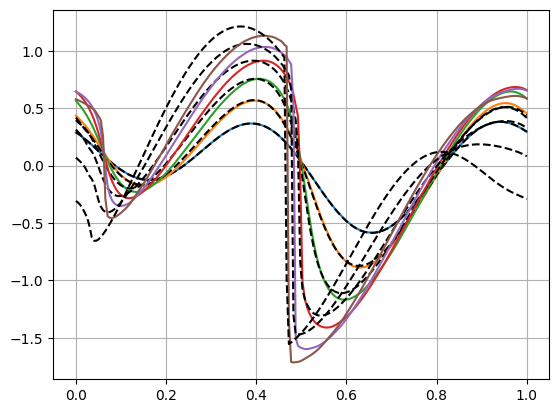

In [47]:
t = [ii for ii in range(0,240,40)]
#t = [ii for ii in range(0,10,1)]
samp = 80
for i in t:
    plt.plot(torch.linspace(0,1,200), prediction_B1[samp,:,i])
    #plt.plot(torch.linspace(0,1,256), train_prediction_B1[samp,:,i])
    #plt.plot(torch.linspace(0,1,256), train_actual_B1[samp,:,i], "k--")
    plt.plot(torch.linspace(0,1,200), actual_B1[samp,:,i], "k--")
plt.grid()

In [141]:
def normalized_rmse(predictions, true_values):
  """
  Calculates the Normalized Root Mean Squared Error (nRMSE).

  Args:
    predictions: A array containing the predicted values.
    true_values: A array containing the true values.

  Returns:
    The normalized root mean squared error.
  """
  #print(predictions.shape, true_values.shape)

#   rmse = torch.sqrt(torch.sum((predictions - true_values) ** 2  ) )
  
#   nrmse = rmse /   torch.sqrt(torch.sum((true_values) ** 2) )    #torch.std(true_values)

  rmse = torch.sqrt(torch.mean((predictions - true_values) ** 2, dim = 1 ) )
  nrmse = rmse / torch.sqrt(torch.mean((true_values) ** 2, dim = 1) )    
  
  return torch.mean(nrmse)

In [143]:
prediction_B1.shape

torch.Size([32, 256, 191])

In [145]:
normalized_rmse(prediction_B1, actual_B1)

tensor(0.0241)

In [146]:
normalized_rmse(prediction_B1[:,:,::5], actual_B1[:,:,::5])

tensor(0.0243)

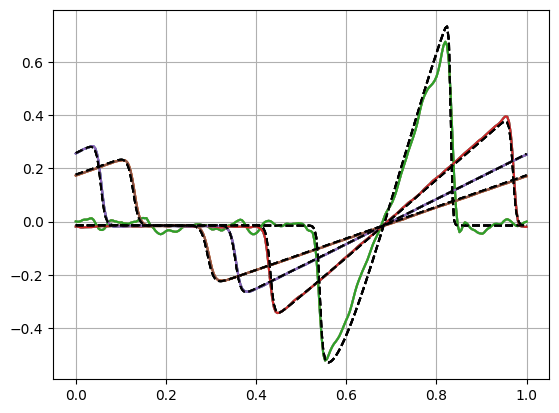

In [52]:
t = [i for i in range(0,191,50)]
samp = 10
for i in t:
    plt.plot(torch.linspace(0,1,256), prediction_B1[samp,:,t])
    plt.plot(torch.linspace(0,1,256), actual_B1[samp,:,t], "k--")
plt.grid()

In [27]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/FNO/multistep_10/run_2/run_2.pt"
test = torch.load(file_loc, map_location="cpu")
print(test.keys())
prediction_E1 = test["train_cons_ro_250"][1]
actual_E1 = test["train_cons_ro_250"][2]

dict_keys(['train_cons_oto_250', 'train_cons_ro_250', 'cons_oto_250', 'cons_ro_250'])


In [6]:
prediction_E1.shape

torch.Size([2048, 100, 249])

In [42]:
normalized_rmse(prediction_E1, actual_E1)

tensor(0.0191)

In [28]:
torch.mean(normalized_rmse(prediction_E1, actual_E1))

tensor(0.1903)

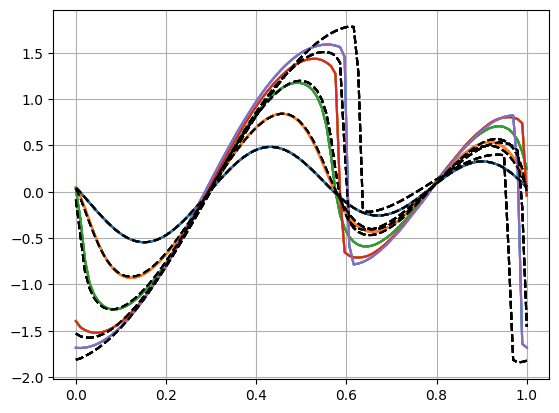

In [22]:
t = [i for i in range(0,250,50)]#[:-50]#[0, 5, 8, 10, 30, 50, 70, 100, 125, 150, 200, 239]
samp = 5
for i in t:
    plt.plot(torch.linspace(0,1,100), prediction_E1[samp,:,t])
    plt.plot(torch.linspace(0,1,100), actual_E1[samp,:,t], "k--")
plt.grid()

In [ ]:
t = [i for i in range(0,10,1)]#[:-50]#[0, 5, 8, 10, 30, 50, 70, 100, 125, 150, 200, 239]
samp = 9
for i in t:
    plt.plot(torch.linspace(0,1,256), prediction_B1[samp,:,t])
    plt.plot(torch.linspace(0,1,256), actual_B1[samp,:,t], "k--")
plt.grid()

In [ ]:
tensor.max()

In [ ]:
tensor.shape

In [5]:
file_loc = "/nobackup/scoc/variable_autoregression/dataset/data/B1/nu_01_testcase_2_n_5000_solution.pt"
tensor_new = torch.load(file_loc, map_location="cpu")


In [22]:
tensor = torch.from_numpy(tensor).float()

In [23]:
tensor_zero_mean = tensor - tensor.mean(-1).unsqueeze(-1)

In [ ]:
tensor_zero_mean = tensor - tensor.mean(-1).unsqueeze(-1)

In [ ]:
for i in range(0,100,50):
    plt.plot(np.linspace(0,10,1024), tensor[i,0,:])
    plt.plot(np.linspace(0,10,1024), tensor[i,-1,:], "--")

    # plt.plot(np.linspace(0,10,1024), tensor_zero_mean[i,0,:])
    # plt.plot(np.linspace(0,10,1024), tensor_zero_mean[i,-1,:], "--")
plt.grid()

In [ ]:
for i in range(0,100,50):

    plt.plot(np.linspace(0,10,1024), tensor_zero_mean[i,0,:])
    plt.plot(np.linspace(0,10,1024), tensor_zero_mean[i,-1,:], "--")
plt.grid()

In [ ]:
for i in range(0,100,100):
    plt.plot(np.linspace(0,10,1024), tensor[i,0,:])
    plt.plot(np.linspace(0,10,1024), tensor[i,-1,:], "--")
plt.grid()

In [ ]:
tensor_new['data_xyt'].shape

In [ ]:
for i in range(0,500,100):
    plt.plot(np.linspace(0,10,1024), tensor_new['data_xyt'][i,0,:], "k--")
    plt.plot(np.linspace(0,10,1024), tensor_new['data_xyt'][i,-1,:], "--")
plt.grid()

In [ ]:
y = torch.rand(10,200)
y_list = []

[y_list.append(y[i]) for i in range(10)]

print(len(y_list))

x = torch.linspace(0,1,200)
x_list = []

[x_list.append(x) for i in range(10)]


print(len(x_list))

#print(y[0].shape, x[0].shape)
y_grad = torch.gradient(y_list,spacing=x_list)
print(len(y_grad))

In [ ]:
x[0].shape

In [2]:
total_range = 250
no_of_samp = (16,50)
dt = 1
init_time_stamp_range = torch.tensor([t for t in range(0, (total_range -  (no_of_samp[1] + ((no_of_samp[1] -1)*(dt-1)) ) + 1 ))])
random_steps = init_time_stamp_range[torch.randint(len(init_time_stamp_range), (no_of_samp[0],))]

indicies = torch.ones((no_of_samp) )
for i in range(no_of_samp[0]):
    start = random_steps[i]
    indicies[i] = torch.arange(start,total_range,dt)[:no_of_samp[1]]

In [ ]:
indicies

In [9]:
dataset_test_path = "/nobackup/scoc/variable_autoregression/dataset/data/KS1/KS_valid_long.h5"
n_test = 5
#hdf5_train_file = h5py.File(args.dataset_train_path, 'r')
hdf5_test_file = h5py.File(dataset_test_path, 'r')
#hdf5_valid_file = h5py.File(args.dataset_valid_path, 'r')

#train_loaded_data = hdf5_train_file['train']['pde_250-100'][:]
test_loaded_data = hdf5_test_file['test']['pde_140-256'][:]
#valid_loaded_data = hdf5_valid_file['valid']['pde_250-100'][:]

#train_tensor =  train_loaded_data.squeeze()
#train_data = torch.from_numpy(train_tensor).float()

test_tensor =  test_loaded_data.squeeze()
test_data = torch.from_numpy(test_tensor).float()

#valid_tensor =  valid_loaded_data.squeeze()
#valid_data = torch.from_numpy(valid_tensor).float()


#x_train = train_data[:argsn_train,...].permute(0,2,1)
x_test = test_data[:n_test,...].permute(0,2,1)
#x_valid = valid_data[:args.n_test,...].permute(0,2,1)

In [ ]:
x_test.shape

In [40]:
import torch
import matplotlib.pyplot as plt
import numpy as np


In [91]:
tmax  = 100
L = 64

In [ ]:
np.random.rand()


In [ ]:
(l1 - l2) * np.random.rand()

In [ ]:
t1 = tmax - tmax / 10
t2 = tmax + tmax / 10
T = (t1 - t2) * np.random.rand() + t2
l1 = L - L / 10
l2 = L + L / 10
L = (l1 - l2) * np.random.rand() + l2

print(T)
print(L)

In [ ]:
# Sample data (replace with your actual tensor)
#data = torch.flip(x_test[3], dims=(0,))

data = x_test[3]

# Move to CPU if necessary
data = data.cpu()

# Plot the colormap
plt.imshow(data, cmap='jet')
plt.gca().invert_yaxis()
plt.xlabel('temporal coordinate')
plt.ylabel('spatial coordinate')
plt.title('Sample Colormap')
plt.colorbar(label='velocity')
plt.show()

In [ ]:
torch.arange(140)[::4].shape

In [ ]:
hdf5_test_file["test"]["x"][:][:,-1].shape

In [ ]:
torch.diff(torch.from_numpy(hdf5_test_file["test"]["t"][:]))[:,0]

In [ ]:
hdf5_test_file["test"]["t"][:][0][1] - hdf5_test_file["test"]["t"][:][0][0]

In [ ]:
hdf5_test_file["test"]["t"][:][:5,-10:]

In [ ]:
hdf5_test_file["test"].keys()

In [3]:

model_path = "/nobackup/scoc/variable_autoregression/result/KS1/debugging/test/run_1/protocol_1.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(model_path, map_location=device)


In [2]:
file_loc = "/nobackup/scoc/variable_autoregression/result/KS1/FNO/baseline_longer_domain/run_1/protocol_1.pt"
test_norm = torch.load(file_loc, map_location="cpu")

In [3]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/FNO/baseline/run_4/protocol_1.pt"
test_no_norm = torch.load(file_loc, map_location="cpu")

In [3]:
prediction_norm = test_norm["saved_epoch"][-1]["error_info"]["test_ro_250"][1]
actual_norm = test_norm["saved_epoch"][-1]["error_info"]["test_ro_250"][2]

In [5]:
prediction_no_norm = test_no_norm["saved_epoch"][-1]["error_info"]["test_ro_250"][1]
actual_no_norm = test_no_norm["saved_epoch"][-1]["error_info"]["test_ro_250"][2]

In [ ]:
torch.mean((prediction_no_norm - actual_no_norm )**2)

In [ ]:
torch.mean((prediction_norm - actual_norm )**2)

In [ ]:
time_indicies = torch.arange(50)

In [ ]:
time_stamps = [i for i in range(0, time_indicies.shape[-1]+1, 2)]

In [ ]:
time_stamps

In [ ]:
prediction_norm.shape

In [6]:

def pearson_correlation(input: torch.Tensor, target: torch.Tensor, reduce_batch: bool = True):
    B = input.size(0)
    T = input.size(1)
    print(input.shape,target.shape)
    input = input.reshape(B, T, -1)
    target = target.reshape(B, T, -1)
    print(input.shape,target.shape)
    input_mean = torch.mean(input, dim=(2), keepdim=True)
    target_mean = torch.mean(target, dim=(2), keepdim=True)
    # Unbiased since we use unbiased estimates in covariance
    input_std = torch.std(input, dim=(2), unbiased=False)
    target_std = torch.std(target, dim=(2), unbiased=False)

    corr = torch.mean((input - input_mean) * (target - target_mean), dim=2) / (input_std * target_std).clamp(
        min=torch.finfo(torch.float32).tiny
    )  # shape (B, T)
    if reduce_batch:
        corr = torch.mean(corr, dim=0)
    return corr



In [ ]:
prediction_norm.shape

In [ ]:
corr.shape

In [ ]:
corr = pearson_correlation(prediction_norm.permute(0,2,1), actual_norm.permute(0,2,1) )
torch.where(corr < 0.8)[0][0]


In [ ]:
data = x_test[3]

# Move to CPU if necessary
data = data.cpu()

# Plot the colormap
plt.imshow(data, cmap='jet')
plt.gca().invert_yaxis()
plt.xlabel('temporal coordinate')
plt.ylabel('spatial coordinate')
plt.title('Sample Colormap')
plt.colorbar(label='velocity')
plt.show()

In [ ]:
t_range =[-31,-30] #[0, 5, 10, 20, 40 , 75, 100, 150, 200, 224, 248]
samp = 20
for t in t_range:
    plt.plot(torch.linspace(0,1,256), prediction_norm[samp,:,t], "b", linewidth=0.9)
    #plt.plot(torch.linspace(0,1,100), prediction_no_norm[samp,:,t], "g", linewidth=0.9)
    plt.plot(torch.linspace(0,1,256), actual_norm[samp,:,t], "k--", linewidth=0.9)

plt.grid()

In [ ]:
# Sample data (replace with your actual arrays)
data1 = prediction_norm[10]  # First array
data2 = actual_norm[10]  # Second array

# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

# Plot data on each subplot
im = ax1.imshow(data1, cmap='jet')  # Replace 'viridis' with your desired colormap
ax1.set_title('Prediction')
ax1.set_xlabel('time')
ax1.set_ylabel('space')

ax2.imshow(data2, cmap='jet')  # Replace 'plasma' with your desired colormap
ax2.set_title('Ground Truth')
#ax2.set_xlabel('X-axis')
#ax2.set_ylabel('Y-axis')

# Get data limits (assuming your data is within [0, 1] range)
data_min = -3.0  # Replace with your minimum value
data_max = 3.0 # Replace with your maximum value

# Create a single colorbar
fig.colorbar(im, ax=[ax1, ax2], label='Colorbar', extend='both' )

# Adjust layout (optional)
#plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Sample data (replace with your actual arrays)
data1 = prediction_norm[5]  # First array
data2 = actual_norm[5]  # Second array

# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

# Plot data on each subplot
im = ax1.imshow(data1, cmap='jet')  # Replace 'viridis' with your desired colormap
ax1.set_title('Prediction')
ax1.set_xlabel('time')
ax1.set_ylabel('space')

ax2.imshow(data2, cmap='jet')  # Replace 'plasma' with your desired colormap
ax2.set_title('Ground Truth')
#ax2.set_xlabel('X-axis')
#ax2.set_ylabel('Y-axis')

# Get data limits (assuming your data is within [0, 1] range)
data_min = -3.0  # Replace with your minimum value
data_max = 3.0 # Replace with your maximum value

# Create a single colorbar
fig.colorbar(im, ax=[ax1, ax2], label='Colorbar', extend='both', boundaries=[data_min, data_max] )

# Adjust layout (optional)
#plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your data
legends = ["MSE Training", "Alternative Losses"]  # Categories for the x-axis
x_data = ["Baseline", "History", "4x parameters", "Ensemble", "",
          "Pushforward", "Sobolev", "MNO", "Error Correction"
          ]  # Categories for the x-axis

y_data_1_1 = [75.4, 61.7, 79.7, 79.7, 0]  # Values for each bar
y_data_1_2 = [60, 61.7, 79.7, 79.7]  # Values for each bar
y_data_1 = y_data_1_1 + y_data_1_2

y_data_2_1 = [70, 54, 71, 72, 0]  # Values for each bar
y_data_2_2 = [57, 54, 71, 72]  # Values for each bar
y_data_2 = y_data_2_1 + y_data_2_2

std_dev_1 = [0, 0, 0, 0,
            0,
             0, 0, 0, 0]
  # Standard deviation for error bars (same length as y_data)
std_dev_2 = [0, 0, 0,0,
             0,
             0, 0, 0, 0]  # Standard deviation for error bars (same length as y_data)

# Create a color list for your bars
colors_1 = ["tab:blue", 
            (0.7, 0.8, 1.0),
            (0.7, 0.8, 1.0),
            (0.7, 0.8, 1.0),

            (0.7, 0.8, 1.0),
            
            (0.5, 0.8, 0.7),
            (0.5, 0.8, 0.7),
            (0.5, 0.8, 0.7),
            (0.5, 0.8, 0.7),]  # You can customize these colors

colors_2 = ["blue",
            (0.2, 0.4, 0.8),
            (0.2, 0.4, 0.8),
            (0.2, 0.4, 0.8),

            (0.7, 0.8, 1.0),

            (0.2, 0.4, 0.15),
            (0.2, 0.4, 0.15),
            (0.2, 0.4, 0.15),
            (0.2, 0.4, 0.15)
            ]  # You can customize these colors

# Create the plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

gap_size = 5
x_positions = [i for i in range(len(x_data))]  # Base positions (equally spaced)
x_positions[4] += gap_size  # Shift the third bar position by the gap size

bars = plt.bar(x_data, y_data_1, color=colors_1, yerr=std_dev_1, capsize=7, zorder=10, label=str(legends[0]))


bars = plt.bar(x_data, y_data_2, color=colors_2, yerr=std_dev_2, capsize=7, zorder=10, label=str(legends[1]))


# Add error bars with the standard deviation
plt.errorbar(x_data, y_data_1, yerr=std_dev_1, fmt='none', ecolor='black', capsize=7)
plt.errorbar(x_data, y_data_2, yerr=std_dev_2, fmt='none', ecolor='black', capsize=7)

bar_heights = y_data_1
for i, height in enumerate(bar_heights):
  if i != 4:
    plt.text(i, height + 4, r"$" + str(height)+ " s" +"$", ha='center', va='bottom', fontsize=13)

#bars[4].set_width(bars[4].get_width() * 1.0)  # Increase width by 50% (adjust multiplier)

# bar_heights = y_data_1
# for i, height in enumerate(bar_heights):
#   plt.text(i, height + 4, r"$" + str(height)+ " s" +"$", ha='center', va='bottom', fontsize=10)





# Customize the plot
#plt.xlabel("Categories")
plt.ylabel("Coreelation time")
plt.title("Bar Plot with Error Bars")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability (optional)
#plt.grid(axis='y', linestyle='-', alpha=1)  # Add gridlines (optional)
plt.grid(axis='y', zorder=0)  # Add gridlines (optional)
plt.ylim([50,100])
# Display the legend (optional)



plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your data
legends = ["MSE Training", "Alternative Losses"]  # Categories for the x-axis
x_data = ["Baseline", "History", "4x parameters", "Ensemble", "",
          "Pushforward", "Sobolev", "MNO", "Error Correction"
          ]  # Categories for the x-axis

y_data_1_1 = [75.4, 61.7, 79.7, 79.7, 0]  # Values for each bar
y_data_1_2 = [60, 61.7, 79.7, 79.7]  # Values for each bar
y_data_1 = y_data_1_1 + y_data_1_2

y_data_2_1 = [70, 54, 71, 72, 0]  # Values for each bar
y_data_2_2 = [57, 54, 71, 72]  # Values for each bar
y_data_2 = y_data_2_1 + y_data_2_2

std_dev_1 = [0, 0, 0, 0,
            0,
             0, 0, 0, 0]
  # Standard deviation for error bars (same length as y_data)
std_dev_2 = [0, 0, 0,0,
             0,
             0, 0, 0, 0]  # Standard deviation for error bars (same length as y_data)

# Create a color list for your bars
colors_1 = ["tab:blue", 
            (0.7, 0.8, 1.0),
            (0.7, 0.8, 1.0),
            (0.7, 0.8, 1.0),

            (0.7, 0.8, 1.0),
            
            (0.5, 0.8, 0.7),
            (0.5, 0.8, 0.7),
            (0.5, 0.8, 0.7),
            (0.5, 0.8, 0.7),]  # You can customize these colors

colors_2 = ["blue",
            (0.2, 0.4, 0.8),
            (0.2, 0.4, 0.8),
            (0.2, 0.4, 0.8),

            (0.7, 0.8, 1.0),

            (0.2, 0.4, 0.15),
            (0.2, 0.4, 0.15),
            (0.2, 0.4, 0.15),
            (0.2, 0.4, 0.15)
            ]  # You can customize these colors

# Create the plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

gap_size = 5
x_positions = [i for i in range(len(x_data))]  # Base positions (equally spaced)
x_positions[4] += gap_size  # Shift the third bar position by the gap size

bars = plt.bar(x_data, y_data_1, color=colors_1, yerr=std_dev_1, capsize=7, zorder=10, label=str(legends[0]))


bars = plt.bar(x_data, y_data_2, color=colors_2, yerr=std_dev_2, capsize=7, zorder=10, label=str(legends[1]))


# Add error bars with the standard deviation
plt.errorbar(x_data, y_data_1, yerr=std_dev_1, fmt='none', ecolor='black', capsize=7)
plt.errorbar(x_data, y_data_2, yerr=std_dev_2, fmt='none', ecolor='black', capsize=7)

bar_heights = y_data_1
for i, height in enumerate(bar_heights):
  if i != 4:
    plt.text(i, height + 4, r"$" + str(height)+ " s" +"$", ha='center', va='bottom', fontsize=13)

#bars[4].set_width(bars[4].get_width() * 1.0)  # Increase width by 50% (adjust multiplier)

# bar_heights = y_data_1
# for i, height in enumerate(bar_heights):
#   plt.text(i, height + 4, r"$" + str(height)+ " s" +"$", ha='center', va='bottom', fontsize=10)





# Customize the plot
#plt.xlabel("Categories")
plt.ylabel("MSE Error")
plt.title("Bar Plot with Error Bars")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability (optional)
#plt.grid(axis='y', linestyle='-', alpha=1)  # Add gridlines (optional)
plt.grid(axis='y', zorder=0)  # Add gridlines (optional)
plt.ylim([50,100])
# Display the legend (optional)



plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
y_data_1

In [ ]:
import matplotlib.pyplot as plt

# Sample data
x_data = ["Group A", "Group B", "Group C", "Group D"]
y_data = [25, 30, 22, 18]

# Create bars with labels (skip legend for the third bar)
bars1 = plt.bar(x_data[:2], y_data[:2], color='blue', label='Group 1-2')
bars2 = plt.bar(x_data[2:], y_data[2:], color='red', label='Group 3-4')  # Skip legend for this bar

# ... (rest of your plot customization code)
plt.legend()  # Display the legend (only includes bars with labels)


In [ ]:
data1 = [25, 30, 22]  # Data for the first bar plot
data2 = [18, 22, 19]  # Data for the second bar plot

x_data1 = range(len(data1))  # Positions for the first bar plot

plt.bar(x_data1, data1, color='blue', label='Plot 1', alpha=0.7)
plt.bar(x_data1, data2, color='red', label='Plot 2', alpha=0.9)



In [ ]:
t_range = [0, 20, 40 , 75, 100, 150, 200, 224]
samp = 5
for t in t_range:
    plt.plot(torch.linspace(0,1,100), prediction[samp,:,t])
    plt.plot(torch.linspace(0,1,100), actual[samp,:,t], "k--")

plt.grid()

In [ ]:
t_range = [0, 20, 40 ,75, 100, 150, 200, 224]
samp = 5
for t in t_range:
    plt.plot(torch.linspace(0,1,100), prediction[samp,:,t])
    plt.plot(torch.linspace(0,1,100), actual[samp,:,t], "k--")

plt.grid()

In [2]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/transformer/debugging/run_3/run_3_proto_1.pt"
var_run_3 = torch.load(file_loc, map_location="cpu")

In [ ]:
var_run_3["train_cons_ro_250"][1].shape

In [ ]:
for i in range(0,245,10):
    plt.plot(torch.linspace(0,1,200), var_run_3["train_cons_ro_250"][1][0,:,i])
    plt.plot(torch.linspace(0,1,200), var_run_3["train_cons_ro_250"][2][0,:,i], "k--")

In [ ]:
var_run_3.keys()

### constant model

In [ ]:
file_loc = "/nobackup/scoc/constant_autoregression/result/2024-05-03/fno_rand_2R0_1AA_25B/protocol_2.pt"
test_128_const = torch.load(file_loc, map_location="cpu")

In [ ]:
pred_250_const = test_128_const["saved_epoch"][-1]["prediction"]["test_225"]
act_250_const = test_128_const["saved_epoch"][-1]["actual"]["test_225"]

In [ ]:
error_250_const = torch.mean((pred_250_const - act_250_const)**2, dim=[0,1])

### variable model

In [ ]:
t_prior_75 = torch.cat((torch.arange(0,50,1),torch.arange(50,250,4)), dim=-1)

In [ ]:
t_prior_175 = torch.cat((torch.arange(0,150,1),torch.arange(150,250,2)), dim=-1)

In [ ]:
rr = torch.cat(( torch.sort(torch.randint(25,(16,25)))[0], torch.arange(25,250)[torch.sort(torch.randint(225,(16,175)))[0]]), dim=-1)

In [ ]:
rr[4]

In [ ]:


t_rand_75 = torch.tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  26,  28,  28,
          32,  35,  37,  40,  43,  49,  51,  58,  59,  60,  63,  68,  68,  68,
          69,  71,  71,  72,  74,  75,  81,  89,  98, 118, 121, 121, 125, 125,
         128, 129, 130, 134, 135, 136, 136, 137, 138, 140, 142, 145, 148, 150,
         151, 154, 158, 159, 166, 167, 168, 173, 182, 184, 190, 190, 190, 195,
         208, 214, 220, 225, 225, 227, 227, 230, 230, 239, 245, 248, 249, 249,
         249, 249]])



t_rand_175 =  torch.tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  26,
          27,  29,  31,  31,  33,  34,  35,  35,  36,  37,  38,  43,  43,  49,
          51,  52,  53,  53,  53,  53,  55,  55,  56,  58,  61,  62,  62,  64,
          66,  69,  70,  71,  72,  73,  74,  74,  78,  78,  79,  80,  83,  84,
          84,  85,  85,  88,  88,  89,  91,  92,  92,  92,  95,  96,  98,  98,
          98, 100, 100, 101, 101, 102, 103, 103, 103, 105, 108, 108, 109, 111,
         112, 116, 117, 119, 119, 119, 122, 126, 129, 130, 131, 131, 132, 133,
         134, 134, 134, 138, 139, 141, 146, 148, 149, 149, 150, 152, 153, 155,
         155, 161, 162, 164, 167, 168, 168, 168, 169, 171, 174, 174, 176, 176,
         176, 179, 180, 182, 182, 182, 186, 187, 187, 189, 189, 190, 190, 191,
         194, 195, 195, 196, 196, 198, 203, 203, 209, 209, 210, 210, 210, 210,
         211, 211, 213, 213, 214, 215, 216, 217, 219, 226, 228, 228, 228, 228,
         229, 233, 234, 235, 236, 238, 239, 239, 240, 241, 242, 243, 243, 244,
         245, 247, 249, 249]])

In [ ]:
t_rand_175[0,:25]

In [ ]:
file_loc = "/nobackup/scoc/variable_autoregression/result/2024-05-28/testingg/test_result_epoch_30_75.pt"
test_128_var_test = torch.load(file_loc, map_location="cpu")

In [ ]:
pred_var_rand_75 = test_128_var_test["prediction"]["const_250"]
act_var_rand_75 = test_128_var_test["true"]["const_250"]

In [ ]:
error_var_rand_75 = torch.mean((pred_var_rand_75 - act_var_rand_75)**2, dim=[0,1])

In [ ]:
torch.mean((pred_var_rand_75 - act_var_rand_75)**2)

In [ ]:
pred_var_prior_75 = test_128_var_test["prediction"]["var_100"]
act_var_prior_75 = test_128_var_test["true"]["var_100"]

In [ ]:
error_var_prior_75 = torch.mean((pred_var_prior_75 - act_var_prior_75)**2, dim=[0,1])

In [ ]:
torch.mean((pred_var_prior_75 - act_var_prior_75)**2)

In [ ]:
file_loc = "/nobackup/scoc/variable_autoregression/result/2024-05-28/testingg/test_result_epoch_30_175.pt"
test_128_var_test_175 = torch.load(file_loc, map_location="cpu")

pred_var_rand_175 = test_128_var_test_175["prediction"]["const_250"]
act_var_rand_175 = test_128_var_test_175["true"]["const_250"]
error_var_rand_175 = torch.mean((pred_var_rand_175 - act_var_rand_175)**2, dim=[0,1])

pred_var_prior_175 = test_128_var_test_175["prediction"]["var_100"]
act_var_prior_175 = test_128_var_test_175["true"]["var_100"]
error_var_prior_175 = torch.mean((pred_var_prior_175 - act_var_prior_175)**2, dim=[0,1])

In [ ]:
t_rand_75

In [ ]:
t_rand_75[0,-75:]

In [ ]:
t_prior_75[-75:]

In [ ]:
t_prior_75.shape

In [ ]:
plt.plot(torch.arange(25,250), error_250_const, "-*", markersize=0.5, label="constant model (225 steps)")

plt.plot(t_rand_175[0,-175:], error_var_rand_175, "-*", markersize=4, label="Variable Model (random 175 steps)")
plt.plot(t_prior_175[-175:], error_var_prior_175, "g-+", markersize=4, label="Variable Model (prior 175 steps)")

plt.plot(t_rand_75[0,-75:], error_var_rand_75, "r-o", markersize=4, label="Variable Model (random 75 steps)")
plt.plot(t_prior_75[-75:], error_var_prior_75, "b-x", markersize=4, label="Variable Model (prior 75 steps)")

plt.grid()
# plt.xscale("log")
plt.yscale("log")
plt.xlabel("time steps")
plt.ylabel("MSE Error")
plt.xticks(torch.arange(0,251,25))
plt.legend()

In [ ]:
torch.cat((torch.arange(0,25, 1),torch.arange(27,250,3)), dim=-1).shape

In [ ]:
torch.cat((torch.arange(0,200, 1),torch.arange(201,250,2)), dim=-1).shape

In [ ]:
torch.sort(torch.randint(250,  (1,75) ))[0]

In [ ]:
torch.cat((torch.arange(0,100, 1),torch.arange(100,250,3)), dim=-1)

In [ ]:
file_loc = "result/2024-05-17/test/test_result_epoch_8_250_75.pt"
res_test = torch.load(file_loc, map_location="cpu")

In [ ]:
pred_250 = res_test["prediction"]["const_250"]
act_250 = res_test["true"]["const_250"]

In [ ]:
pred_75 = res_test["prediction"]["var_75"]
act_75 = res_test["true"]["var_75"]

In [ ]:
torch.mean((pred_250 -act_250)**2, dim=[0,1]).sum()

In [ ]:
no_of_samp = (20,75)
total_range = 250

init_time_stamp_range = torch.tensor([t for t in range(0, total_range -  no_of_samp[1])])
#print("init_time_stamp_range -->", init_time_stamp_range[0], init_time_stamp_range[-1] )
random_steps = init_time_stamp_range[torch.randint(len(init_time_stamp_range), (no_of_samp[0],))]

#print("random_steps -->", random_steps)
indicies = torch.ones((no_of_samp) )
#indicies = torch.sort(torch.randint(total_range, (no_of_samp)))[0]
for i in range(no_of_samp[0]):
    start = random_steps[i]
    #print("start -->", start)
    final_time_stamp_range = torch.tensor([t for t in range(start +  no_of_samp[1] , total_range)])
    #print("final_time_stamp_range -->", final_time_stamp_range[0], final_time_stamp_range[-1] )

    end = final_time_stamp_range[torch.randperm(len(final_time_stamp_range))[0]]
    #print("end -->", end)

    indicies[i] = torch.sort(start + torch.randint(end-start, (1,no_of_samp[1]) ))[0]
    #print("indicies -->", ind)

    #indicies[i] = ind


In [ ]:
indicies[4,:]

In [ ]:
indicies[:,0]

In [ ]:
indicies[:,-1]

In [ ]:
torch.sort(random_steps + torch.randint(total_range -random_steps, (1,75) ) )[0]

In [ ]:
torch.mean((pred_250 -act_250)**2)

In [ ]:
torch.mean((pred_250[...,-1] -act_250[...,-1])**2, dim=[0,1])

In [ ]:
torch.mean((pred_75[...,-1] -act_75[...,-1])**2, dim=[0,1])

In [ ]:
torch.mean((pred_75 -act_75)**2)

In [ ]:
torch.mean((pred_225[...,-1] -act_225[...,-1])**2, dim=[0,1])

In [ ]:
pred_250.shape

In [ ]:
torch.mean((pred_250[...,-1] -act_250[...,-1])**2, dim=[0,1]).sum()

In [ ]:
pred_250 = res_test["prediction"]["const_250"]
act_250 = res_test["true"]["const_250"]

In [ ]:
pred_150.shape

In [ ]:
torch.mean((pred_var75_var -act_var75_var)**2)

In [ ]:
t = [0, 1, 2, 10, 20, 30, 48, 49]
#t = [0, 1, 2, 10, 20, 30, 40, 48, 49,70, 110, 120, 124, 170,200, 223,224]
samp = 127
for i in range(len(t)):
    plt.plot(torch.linspace(0,1,100), pred_var75_var[samp,:,t[i]])
    plt.plot(torch.linspace(0,1,100), act_var75_var[samp,:,t[i]], "k--")
plt.grid()

In [ ]:
#t = [0, 1, 2, 10, 20, 30, 48, 49, 75, 100, 125, 150, 210, 224]
t = [0, 1, 2, 10, 20, 30, 40, 48, 49]
samp = 4
for i in range(len(t)):
    plt.plot(torch.linspace(0,1,100), pred_75[samp,:,t[i]])
    plt.plot(torch.linspace(0,1,100), act_75[samp,:,t[i]], "k--")
plt.grid()

In [ ]:
t = [0, 1, 2, 10, 20, 224]
#t = [ i for i in range(200,225)]
#t = [ i for i in range(0,25)]
samp = 30
for i in range(len(t)):
    plt.plot(torch.linspace(0,1,100), pred_250[samp,:,t[i]])
    plt.plot(torch.linspace(0,1,100), act_250[samp,:,t[i]], "k--")
plt.grid()

In [ ]:
#t = [0, 1, 2, 10, 20, 30, 48, 49, 75, 100, 125, 150, 210, 224]
t = [0, 1, 2,  49]
samp = 30
for i in range(len(t)):
    plt.plot(torch.linspace(0,1,100), pred_75[samp,:,t[i]])
    plt.plot(torch.linspace(0,1,100), act_75[samp,:,t[i]], "k--")
plt.grid()

In [ ]:
t = [0, 1, 2, 10, 20, 30, 48, 49, 75, 100, 125, 150, 210, 220, 224]
#t = [ i for i in range(200,225)]
t = [ i for i in range(0,25)]
samp = 30
for i in range(len(t)):
    #plt.plot(torch.linspace(0,1,100), pred_250[samp,:,t[i]])
    plt.plot(torch.linspace(0,1,100), act_250[samp,:,t[i]], "k--")
plt.grid()

In [ ]:
t = [0, 1, 2, 10, 20, 30, 48, 49]
samp = 31
for i in range(len(t)):
    plt.plot(torch.linspace(0,1,100), pred[samp,:,t[i]])
    plt.plot(torch.linspace(0,1,100), act[samp,:,t[i]], "k--")
plt.grid()

In [ ]:
sss = torch.randint(50, (5,10))
print(sss.shape)

In [ ]:
torch.sort(sss)[0]

In [ ]:
x = torch.rand((5,50))
x = x.unsqueeze(1).repeat((1,100,1))
print(x.shape)

In [ ]:
hdf5_train_file = h5py.File("dataset/data/CE_train_E1.h5", 'r')

train_loaded_data = hdf5_train_file['train']['pde_250-100'][:]

train_tensor =  train_loaded_data.squeeze()
train_data = torch.from_numpy(train_tensor).float()

x_train = train_data[:16,...].permute(0,2,1)


In [ ]:
x_train.shape

In [ ]:
sss = torch.sort(torch.randint(250, (16,10)))[0]
sss

In [ ]:
x_train_sub = torch.gather(x_train, -1, sss.unsqueeze(1).repeat((1,100,1))) 
x_train_sub.shape

In [ ]:
plt.plot(torch.linspace(0,1,100), x_train_sub[5,:,6])
plt.plot(torch.linspace(0,1,100), x_train[5,:,sss[5,6]], "k--")


In [ ]:
torch.randperm(10)

In [ ]:
x[4,sss[3,:]]

## Multistep=10

In [ ]:
torch.cat((torch.arange(0,50, 1),torch.arange(50,250,4)), dim=-1)

In [ ]:
torch.cat((torch.arange(0,150,1),torch.arange(150,250,2)), dim=-1)

In [ ]:
torch.cat(( torch.arange(0,10).unsqueeze(0), torch.arange(10,250)[torch.sort(torch.randint(240,(1,190)))[0]]), dim=-1)

In [ ]:
t_100 = torch.tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  12,  22,  25,
          26,  27,  27,  38,  39,  41,  44,  47,  50,  52,  55,  56,  57,  66,
          68,  71,  73,  75,  76,  77,  81,  83,  84,  84,  85,  94,  96, 102,
         102, 104, 110, 112, 117, 118, 120, 122, 122, 123, 134, 139, 142, 149,
         154, 154, 155, 159, 162, 162, 166, 169, 171, 175, 176, 177, 178, 183,
         186, 189, 191, 198, 198, 200, 201, 202, 202, 203, 206, 207, 208, 209,
         219, 223, 225, 226, 230, 230, 234, 235, 237, 237, 238, 238, 238, 241,
         247, 249]])

t_200 = torch.tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  14,
          15,  16,  18,  18,  19,  19,  20,  22,  23,  27,  27,  30,  30,  30,
          30,  31,  32,  32,  33,  33,  35,  36,  36,  39,  41,  42,  47,  48,
          48,  50,  50,  54,  54,  57,  57,  57,  57,  60,  64,  67,  67,  67,
          68,  69,  70,  71,  76,  76,  77,  78,  79,  81,  82,  83,  84,  86,
          88,  91,  91,  92,  92,  93,  95,  95, 100, 100, 101, 102, 102, 102,
         103, 103, 106, 106, 107, 108, 109, 110, 111, 113, 116, 117, 118, 118,
         121, 121, 123, 125, 125, 125, 135, 136, 136, 137, 137, 137, 137, 137,
         138, 139, 140, 140, 140, 140, 143, 144, 145, 147, 148, 149, 150, 150,
         152, 152, 155, 156, 156, 157, 159, 160, 161, 166, 169, 170, 171, 171,
         172, 173, 173, 174, 175, 176, 178, 180, 180, 182, 186, 187, 190, 191,
         193, 194, 194, 194, 200, 200, 200, 201, 204, 207, 208, 210, 211, 211,
         213, 213, 213, 218, 218, 218, 221, 222, 222, 222, 222, 224, 226, 227,
         227, 227, 228, 229, 230, 232, 233, 234, 237, 242, 242, 243, 244, 246,
         246, 246, 248, 249]])

In [ ]:
file_loc = "/nobackup/scoc/constant_autoregression/result/2024-05-04/fno_rand_5R0_4AA_10B_1/protocol_1.pt"
test_128_const = torch.load(file_loc, map_location="cpu")

In [ ]:
pred_const = test_128_const["saved_epoch"][-1]["prediction"]["test_225"]
act_const = test_128_const["saved_epoch"][-1]["actual"]["test_225"]

In [ ]:
error_const = torch.mean((pred_const - act_const)**2, dim=[0,1])

In [ ]:
file_loc = "/nobackup/scoc/variable_autoregression/result/2024-05-20/testinggg/test_result_epoch_20_250_100_b10.pt"
test_128_var = torch.load(file_loc, map_location="cpu")

In [ ]:
file_loc = "/nobackup/scoc/variable_autoregression/result/2024-05-20/testinggg/test_result_epoch_20_250_200_b10.pt"
test_128_var_200 = torch.load(file_loc, map_location="cpu")

In [ ]:
pred_90_varand = test_128_var["prediction"]["const_250"]
act_90_varand = test_128_var["true"]["const_250"]

In [ ]:
pred_190_varand = test_128_var_200["prediction"]["const_250"]
act_190_varand = test_128_var_200["true"]["const_250"]

In [ ]:
torch.mean((pred_190_varand[...,-1] - act_190_varand[...,-1])**2)

In [ ]:
pred_90_varand.shape

In [ ]:
error_190_varand = torch.mean((pred_190_varand - act_190_varand)**2, dim=[0,1])

In [ ]:
error_90_varand = torch.mean((pred_90_varand - act_90_varand)**2, dim=[0,1])

In [ ]:
torch.mean((pred_90_varand[...,-1] - act_90_varand[...,-1])**2)

In [ ]:
pred_90_var = test_128_var["prediction"]["var_100"]
act_90_var = test_128_var["true"]["var_100"]

In [ ]:
pred_190_var = test_128_var_200["prediction"]["var_100"]
act_190_var = test_128_var_200["true"]["var_100"]

In [ ]:
torch.mean((pred_190_varand[...,-3] - act_190_varand[...,-3])**2)

In [ ]:
torch.mean((pred_190_var[...,-2] - act_190_var[...,-2])**2)

In [ ]:
torch.mean((pred_90_var - act_90_var)**2)

In [ ]:
error_190_var = torch.mean((pred_190_var - act_190_var)**2, dim=[0,1])

In [ ]:
error_90_var = torch.mean((pred_90_var - act_90_var)**2, dim=[0,1])

In [ ]:
plt.plot(torch.arange(10,250), error_const, "-*", markersize=0.5, label="constant model (240 steps)")

plt.plot(t_200[0,-190:], error_190_varand, "-*", markersize=4, label="Variable Model (random 190 steps)")
plt.plot(torch.cat((torch.arange(0,150,1),torch.arange(150,250,2)), dim=-1)[-190:], error_190_var, "g-+", markersize=4, label="Variable Model (prior 190 steps)")

plt.plot(t_100[0,-90:], error_90_varand, "r-o", markersize=4, label="Variable Model (random 90 steps)")
plt.plot(torch.cat((torch.arange(0,50,1),torch.arange(50,250,4)), dim=-1)[-90:], error_90_var, "b-x", markersize=4, label="Variable Model (prior 90 steps)")

plt.grid()
#plt.xscale("log")
plt.yscale("log")
plt.xlabel("time steps")
plt.ylabel("MSE Error")
#plt.xticks(torch.arange(0,251,25))
#plt.ylim([0.01,2])
plt.legend()

## Attention

In [ ]:
import torch.nn as nn

class SelfAttention(nn.Module):
  def __init__(self, d_model):
    super(SelfAttention, self).__init__()
    self.d_k = d_model // 8  # Dimension of key and value vectors (adjustable)
    self.wq = nn.Linear(d_model, self.d_k, bias=False)  # Query projection
    self.wk = nn.Linear(d_model, self.d_k, bias=False)  # Key projection
    self.wv = nn.Linear(d_model, self.d_k, bias=False)  # Value projection
    #self.v_up = nn.Linear(25, 50, bias=False)  # Value projection
    self.softmax = nn.Softmax(dim=-1)  # Softmax for attention scores

  def forward(self, x,  x_tembed, y_tembed):
    # Project input using query, key, and value weights

    q = self.wq( x + y_tembed )
    k = self.wk( x + x_tembed)
    #print(self.v_up(x.permute(0,2,1)).permute(0,2,1).shape)
    v = self.wv(x)

    print(q.shape, k.shape, v.shape)

    # Calculate attention scores
    scores  = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k) )  # Scaled dot-product attention

    # Apply softmax to normalize attention scores
    attention = self.softmax(scores)

    # Context vector as weighted sum of values
    context = torch.matmul( attention, v)

    # Return context vector and attention scores (optional)
    return context, attention  # You can return only context if needed
  

In [ ]:
x = torch.rand(16,25,200)
x_t = torch.rand(16,25,200)
y_t = torch.rand(16,25,200)

In [ ]:
attend = SelfAttention(200)

v,a = attend(x,x_t,y_t)

In [ ]:
a.shape

## UNO

In [ ]:
import torch.functional as F
import torch.nn as nn

In [ ]:

class SpectralConv1d_Uno(nn.Module):
    def __init__(self, in_codim, out_codim, dim1,modes1 = None):
        super(SpectralConv1d_Uno, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT. 
        dim1 = Default output grid size along x (or 1st dimension of output domain) 
        Ratio of grid size of the input and the output implecitely 
        set the expansion or contraction farctor along each dimension of the domain.
        modes1 = Number of fourier modes to consider for the integral operator.
                Number of modes must be compatibale with the input grid size 
                and desired output grid size.
                i.e., modes1 <= min( dim1/2, input_dim1/2). 
                Here "input_dim1" is the grid size along x axis (or first dimension) of the input domain.
        in_codim = Input co-domian dimension
        out_codim = output co-domain dimension
        """
        in_codim = int(in_codim)
        out_codim = int(out_codim)
        self.in_channels = in_codim
        self.out_channels = out_codim
        self.dim1 = dim1 #output dimensions
        if modes1 is not None:
            self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        else:
            self.modes1 = dim1//2

        self.scale = (1 / (2*in_codim))**(1.0/2.0)
        self.weights1 = nn.Parameter(self.scale * torch.randn(in_codim, out_codim, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x, dim1 = None):
        """
        input shape = (batch, in_codim, input_dim1)
        output shape = (batch, out_codim, dim1)
        """
        #import pdb; pdb.set_trace()
        if dim1 is not None:
            self.dim1 = dim1
        batchsize = x.shape[0]

        x_ft = torch.fft.rfft(x, norm = 'forward')

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  self.dim1//2 + 1 , dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=self.dim1, norm = 'forward')
        return x

class pointwise_op_1D(nn.Module):
    """
    All variables are consistent with the SpectralConv1d_Uno class.
    """
    def __init__(self, in_codim, out_codim,dim1):
        super(pointwise_op_1D,self).__init__()
        self.conv = nn.Conv1d(int(in_codim), int(out_codim), 1)
        self.dim1 = int(dim1)

    def forward(self,x, dim1 = None):
        import pdb; pdb.set_trace()
        if dim1 is None:
            dim1 = self.dim1
        x_out = self.conv(x)

        x_out = torch.nn.functional.interpolate(x_out, size = dim1,mode = 'linear',align_corners=True, antialias= True)
        return x_out



class OperatorBlock_1D(nn.Module):
    """
    Normalize = if true performs InstanceNorm1d on the output.
    Non_Lin = if true, applies point wise nonlinearity.
    All other variables are consistent with the SpectralConv1d_Uno class.
    """
    def __init__(self, in_codim, out_codim,dim1,modes1, Normalize = True,Non_Lin = True):
        super(OperatorBlock_1D,self).__init__()
        self.conv = SpectralConv1d_Uno(in_codim, out_codim, dim1,modes1)
        self.w = pointwise_op_1D(in_codim, out_codim, dim1)
        self.normalize = Normalize
        self.non_lin = Non_Lin
        if Normalize:
            self.normalize_layer = torch.nn.InstanceNorm1d(int(out_codim),affine=True)


    def forward(self,x, dim1 = None):
        """
        input shape = (batch, in_codim, input_dim1)
        output shape = (batch, out_codim, dim1)
        """
        #import pdb; pdb.set_trace()
        x1_out = self.conv(x,dim1)
        x2_out = self.w(x,dim1)
        x_out = x1_out + x2_out
        if self.normalize:
            x_out = self.normalize_layer(x_out)
        if self.non_lin:
            x_out = F.gelu(x_out)
        return x_out



# UNO model 
# it has less aggressive scaling factors for domains and co-domains.
# ####    
class UNO_1D(nn.Module):
    def __init__(self,in_width, width,pad = 0, factor = 3/4):
        super(UNO_1D, self).__init__()


        self.in_width = in_width # input channel
        self.width = width 
        self.factor = factor
        self.padding = pad  

        self.fc0 = nn.Linear(self.width, self.width) # input channel is 3: (a(x), x)

        self.L0 = OperatorBlock_1D(self.width, 2*factor*self.width,48, 22)

        self.L1 = OperatorBlock_1D(2*factor*self.width, 4*factor*self.width, 32, 14)

        self.L2 = OperatorBlock_1D(4*factor*self.width, 8*factor*self.width, 16, 6,)
        
        self.L3 = OperatorBlock_1D(8*factor*self.width, 8*factor*self.width, 16, 6)
        
        self.L4 = OperatorBlock_1D(8*factor*self.width, 4*factor*self.width, 32, 6)

        self.L5 = OperatorBlock_1D(8*factor*self.width, 2*factor*self.width, 48,14)

        self.L6 = OperatorBlock_1D(4*factor*self.width, self.width, 64, 22) # will be reshaped

        self.fc1 = nn.Linear(2*self.width, 4*self.width)
        self.fc2 = nn.Linear(4*self.width, 1)

    def forward(self, x):
        #import pdb; pdb.set_trace()
        grid = self.get_grid(x.shape, x.device)
        print("x ->",x.shape)
        x = torch.cat((x, grid), dim=-1)

        print("x + grid ->",x.shape)
         
        x_fc0 = self.fc0(x)

        print("x_fc0 ->",x_fc0.shape)

        x_fc0 = x_fc0.permute(0, 2, 1)
        
        print("x_fc0 ->",x_fc0.shape)
        
        x_fc0 = F.pad(x_fc0, [self.padding,self.padding, self.padding,self.padding])
        
        print("x_fc0 pad ->",x_fc0.shape)

        D1,D2 = x_fc0.shape[-2],x_fc0.shape[-1]
        
        x_c0 = self.L0(x_fc0,int(D1*self.factor),int(D2*self.factor))

        print("x_c0 ->",x_fc0.shape)

        
        x_c1 = self.L1(x_c0 ,D1//2,D2//2)

        x_c2 = self.L2(x_c1 ,D1//4,D2//4)        
        x_c3 = self.L3(x_c2,D1//4,D2//4)
        x_c4 = self.L4(x_c3,D1//2,D2//2)
        x_c4 = torch.cat([x_c4, x_c1], dim=1)
        x_c5 = self.L5(x_c4,int(D1*self.factor),int(D2*self.factor))
        x_c5 = torch.cat([x_c5, x_c0], dim=1)
        x_c6 = self.L6(x_c5,D1,D2)
        x_c6 = torch.cat([x_c6, x_fc0], dim=1)

        if self.padding!=0:
            x_c6 = x_c6[..., :-self.padding, :-self.padding]

        x_c6 = x_c6.permute(0, 2, 3, 1)
        
        x_fc1 = self.fc1(x_c6)
        x_fc1 = F.gelu(x_fc1)
        
        x_out = self.fc2(x_fc1)
        
        return x_out
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 2*np.pi, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 2*np.pi, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((torch.sin(gridx),torch.sin(gridy),torch.cos(gridx),torch.cos(gridy)), dim=-1).to(device)


In [ ]:
x = torch.rand(16, 100, 2)
model = UNO_1D (
    32,
    32


)

In [ ]:
out = model(x)

## Norm

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn as nn

In [6]:

class Normalizer_1D(nn.Module):
    """
    Normalizer class for data preprocessing.
    """

    def __init__(self, eps=1e-5):
        """
        Initializes the Normalizer class.

        Args:
            eps: A small value to avoid division by zero (default: 1e-5).
        """
        super(Normalizer_1D, self).__init__()
        # self.register_buffer("running_mean", torch.zeros(1))
        # self.register_buffer("running_std", torch.ones(1))

        self.running_mean = torch.zeros(1).to(device)
        self.running_std = torch.ones(1).to(device)
        self.eps = eps

    def forward(self, x):
        """
        Normalizes the input tensor by subtracting the mean and dividing by the standard deviation.

        Args:
            x: Input tensor.

        Returns:
            Normalized tensor.
        """
        B,D,I = x.shape

        x_pool_dim = x.view(-1, x.shape[-1])

        # if not self.training:
        #     mean = self.running_mean
        #     std = self.running_std
        # else:
        #     # Calculate mean and variance during training
        #     x_pool_dim = x.view(-1, x.shape[-1])
        #     mean = torch.mean(x_pool_dim, dim=0)
        #     std = torch.std(x_pool_dim, dim=0)

        #     self.running_mean =  mean
        #     self.running_std =  std

        # Normalize the input
        #x_hat = (x_pool_dim - mean) / std

        self.running_mean =  x_pool_dim.mean(dim=0)
        self.running_std =  x_pool_dim.std(dim=0)
    
        x_hat = (x_pool_dim - x_pool_dim.mean(dim=0)) / x_pool_dim.std(dim=0)
        return x_hat.view(B,D,I)

    def inverse(self, x_hat):
        """
        Denormalizes the input tensor by reversing the normalization process.

        Args:
            x_hat: Normalized tensor.

        Returns:
            Unnormalized tensor.
        """
        mean = self.running_mean 
        std = self.running_std
        return x_hat * std + mean
    

In [7]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/FNO/horizon_1_norm/run_1/protocol_1.pt"
test_norm = torch.load(file_loc, map_location="cpu")

prediction_norm = test_norm["saved_epoch"][-1]["error_info"]["test_ro_250"][1]
actual_norm = test_norm["saved_epoch"][-1]["error_info"]["test_ro_250"][2]

In [97]:

file_loc = "/nobackup/scoc/variable_autoregression/result/E1/debugging/splits/run_5/protocol_1.pt"
test_norm = torch.load(file_loc, map_location="cpu")

prediction_norm = test_norm["saved_epoch"][-1]["error_info"]["test_oto_250"][1]
actual_norm = test_norm["saved_epoch"][-1]["error_info"]["test_oto_250"][2]

In [94]:
prediction_norm = test_norm["saved_epoch"][-1]["error_info"]["train_oto_250"][1]
actual_norm = test_norm["saved_epoch"][-1]["error_info"]["train_oto_250"][2]

In [ ]:
prediction_norm[0,-10:
                ]

In [ ]:
torch.mean((prediction_norm-actual_norm)**2)

In [ ]:
torch.randint(2,(250,1))


In [ ]:
actual_norm

In [ ]:
samp = 20
plt.plot(torch.arange(1,250), prediction_norm[samp], "*")
plt.plot(torch.arange(1,250), actual_norm[samp], "k--*")

In [ ]:


file_loc = "/nobackup/scoc/variable_autoregression/result/E1/FNO/baseline/run_5/run_5.pt"
test = torch.load(file_loc, map_location="cpu")
print(test.keys())
prediction = test["cons_ro_250"][1]
actual = test["cons_ro_250"][2]

In [47]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/FNO/multistep_25/run_2/protocol_1.pt"
test_ms25 = torch.load(file_loc, map_location="cpu")

prediction_ms25= test_ms25["saved_epoch"][-1]["error_info"]["test_ro_250"][1]
actual_ms25 = test_ms25["saved_epoch"][-1]["error_info"]["test_ro_250"][2]

In [ ]:
torch.max(prediction_norm) #.shape

In [ ]:
t = [-10, -50, -70, -125, -150]

t = [-150, -125, -70, -50, -10]
samp = 4
for i in t:
    #plt.plot(torch.linspace(0,1,100), actual_norm[samp,:,t])
    plt.plot(torch.linspace(0,1,100), prediction_norm[samp,:,i], "g")
    plt.plot(torch.linspace(0,1,100), prediction[samp,:,i], "b")
    plt.plot(torch.linspace(0,1,100), prediction_ms25[samp,:,i], "m")

    plt.plot(torch.linspace(0,1,100), actual_norm[samp,:,i], "k--")
    #plt.plot(torch.linspace(0,1,100), actual_ms25[samp,:,i], "b--")
    #plt.plot(torch.linspace(0,1,100), actual[samp,:,t], "b--")

In [8]:
normalise = Normalizer_1D()

In [ ]:
normalise.running_mean.shape

In [ ]:
torch.std(actual_norm[:5])

In [ ]:
x_norm_1 = normalise(actual_norm[:5])
print(normalise.running_mean, normalise.running_std)
x_unorm_1 = normalise.inverse(x_norm_1)

In [ ]:
x_norm = normalise(actual_norm[:32])
print(normalise.running_mean, normalise.running_std)
x_unorm = normalise.inverse(x_norm)

In [ ]:
t = [10, 50, 70, 125, 150, 240]
samp = 4
for i in t:
    #plt.plot(torch.linspace(0,1,100), actual_norm[samp,:,t])
    plt.plot(torch.linspace(0,1,100), x_norm[samp,:,t], "k--")
    plt.plot(torch.linspace(0,1,100), x_norm_1[samp,:,t], "b--")

    plt.plot(torch.linspace(0,1,100), x_unorm[samp,:,t], )
    plt.plot(torch.linspace(0,1,100), x_unorm_1[samp,:,t], "m--")

In [ ]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/variable_time/FNO_attention/run_19/run_19_proto_1.pt"
test = torch.load(file_loc, map_location="cpu")
print(test.keys())
prediction = test["train_var_ro_250"][1]
actual = test["train_var_ro_250"][2]

In [ ]:
prediction.shape

In [ ]:
t = [i for i in range(0,250,25)]#[:-50]#[0, 5, 8, 10, 30, 50, 70, 100, 125, 150, 200, 239]
samp = 29
for i in t:
    plt.plot(torch.linspace(0,1,200), prediction[samp,:,t])
    plt.plot(torch.linspace(0,1,200), actual[samp,:,t], "k--")
plt.grid()

In [ ]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/FNO/debug_seq_constant_time/run_4/run_4_proto_1.pt"
test = torch.load(file_loc, map_location="cpu")
print(test.keys())
prediction = test["train_cons_ro_250"][1]
actual = test["train_cons_ro_250"][2]

In [3]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/FNO/debug_seq_constant_time/no_cl_2/errors.pt"
test_ncl = torch.load(file_loc, map_location="cpu")

In [4]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/FNO/debug_seq_constant_time/discrete_cl_5/errors.pt"
test_dcl = torch.load(file_loc, map_location="cpu")


In [19]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/FNO/debug_seq_constant_time/discrete_cl_5/errors.pt"
test_dcl = torch.load(file_loc, map_location="cpu")

In [5]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/FNO/debug_seq_constant_time/cont_cl_2/errors.pt"
test_ccl = torch.load(file_loc, map_location="cpu")

In [ ]:
plt.plot(torch.arange(1,201), test_ncl[:,4], label="No Curriculum")
plt.plot(torch.arange(1,201), test_dcl[:,4], label="Discrete Curriculum")
plt.plot(torch.arange(1,201), test_ccl[:,4], label="Continuous Curriculum")
plt.grid()
#plt.xscale("log")
plt.yscale("log")
plt.ylim([0.005, 10])
plt.legend(loc="upper center")
plt.xlabel("Epoch", fontsize=12 )
plt.ylabel("Full rollout loss", fontsize=12)

In [ ]:
plt.ylim([0.005, 10])
plt.legend()
plt.xlabel("Epoch", fontsize=12 )
plt.ylabel("Training rollout Loss", fontsize=12)

In [ ]:
file_loc = "/nobackup/scoc/variable_autoregression/result/E1/FNO/debug_seq_constant_time_dwg/run_1/run_1_proto_1.pt"
test = torch.load(file_loc, map_location="cpu")
print(test.keys())
prediction = test["train_cons_ro_250"][1]
actual = test["train_cons_ro_250"][2]

In [ ]:
t = [i for i in range(0,250,50)]#[0, 5, 8, 10, 30, 50, 70, 100, 125, 150, 200, 239]
samp = 4
for i in t:
    plt.plot(torch.linspace(0,1,200), prediction[samp,:,t])
    plt.plot(torch.linspace(0,1,200), actual[samp,:,t], "k--")
plt.grid()

In [ ]:
t = [0, 5, 8, 10, 30, 50, 70, 100, 125, 150, 200, 239]
samp = 25
for i in t:
    plt.plot(torch.linspace(0,1,200), prediction[samp,:,t])
    plt.plot(torch.linspace(0,1,200), actual[samp,:,t], "k--")
plt.grid()

In [ ]:
for param in model.parameters():
    print(f"Gradient of parameter {i} at time step {i+1}: {param.grad}")

## Pretrained model

In [1]:
import torch
import numpy

import h5py
import matplotlib.pyplot as plt

In [28]:

import torch.nn.functional as F
from torch import nn

import numpy as np

In [7]:
# Path to the pretrained model file
model_path = "/nobackup/scoc/variable_autoregression/pretrained_model/1D_Burgers_Sols_Nu0.01_FNO.pt" 

# Load the model
model_info = torch.load(model_path, map_location=torch.device('cpu')) 

In [8]:
model.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])

In [19]:

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super().__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = (
            # Number of Fourier modes to multiply, at most floor(N/2) + 1
            modes1
        )

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale
            * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat)
        )
    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coefficients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            x.size(-1) // 2 + 1,
            device=x.device,
            dtype=torch.cfloat,
        )
        out_ft[:, :, : self.modes1] = self.compl_mul1d(
            x_ft[:, :, : self.modes1], self.weights1
        )

        # Return to physical space
        return torch.fft.irfft(out_ft, n=x.size(-1))


class FNO1d(nn.Module):
    def __init__(self, num_channels, modes=12, width=20, initial_step=10):
        super().__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 2  # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(
            initial_step * num_channels + 1, self.width
        )  # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, num_channels)

    def forward(self, x, grid):
        # x dim = [b, x1, t*v]
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        # pad the domain if input is non-periodic
        x = F.pad(x, [0, self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., : -self.padding]
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x.unsqueeze(-2)

In [20]:
model = FNO1d(num_channels=1)

In [21]:
model

FNO1d(
  (fc0): Linear(in_features=11, out_features=20, bias=True)
  (conv0): SpectralConv1d()
  (conv1): SpectralConv1d()
  (conv2): SpectralConv1d()
  (conv3): SpectralConv1d()
  (w0): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  (w1): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  (w2): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  (w3): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [22]:
model.load_state_dict(model_info["model_state_dict"])

<All keys matched successfully>

In [112]:
hdf5_file = h5py.File('/nobackup/scoc/variable_autoregression/dataset/data/B1/1D_Burgers_Sols_Nu0.01_n_2000.h5', 'r')
time = hdf5_file['t-coordinate'][:]
tensor =  hdf5_file['tensor'][:][:,::5,::4]
x =  hdf5_file['x-coordinate'][:]

In [71]:
tensor.shape

(2000, 41, 256)

In [113]:
def get_grid(shape):
    batchsize, size_x = shape[0], shape[1]
    gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
    gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
    return gridx

torch.Size([1])

In [114]:
initial_step = 10
t_steps = tensor.shape[1] - initial_step
tensor_batch_in = torch.tensor(tensor[:5,:10,]).permute(0,2,1)
grid = get_grid(tensor_batch_in.shape)

In [115]:
prediction = torch.zeros(5, 256, t_steps)
for i in range(t_steps):
    out = model(tensor_batch_in, grid)
    # print(out.shape)
    # print(out.squeeze(-1).shape)
    # print(prediction[...,ii+1].shape)
    prediction[...,i:i+1] = out.squeeze(-1)
    tensor_batch_in = torch.cat((tensor_batch_in[...,1:], out.squeeze(-1) ), dim=-1)


In [116]:
tensor.shape

(2000, 41, 256)

In [117]:
prediction.shape

torch.Size([5, 256, 31])

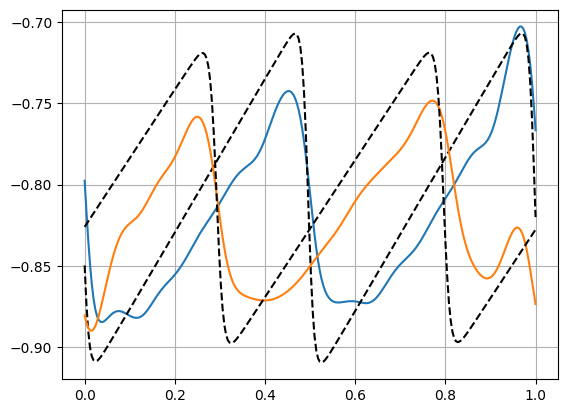

In [168]:
samp = 2
for t in range(25,31,5):
    plt.plot(np.linspace(0,1,256), prediction[samp,:,t].detach().numpy())
    plt.plot(np.linspace(0,1,256), tensor[samp,10+t,:], "k--")
plt.grid()

In [169]:
tensor_t = torch.tensor(tensor)[:5, 10:, :]

In [170]:
tensor_tt = tensor_t - tensor_t.mean(-1, keepdim=True)

In [171]:
normalized_rmse(prediction-prediction.mean(1, keepdim=True) , tensor_tt.permute(0,2,1) )

tensor(0.4292, grad_fn=<MeanBackward0>)

In [172]:
normalized_rmse(prediction, torch.tensor(tensor[:5,10:, :]).permute(0,2,1))

tensor(0.0556, grad_fn=<MeanBackward0>)

In [137]:
mm[1]

tensor(0.0565, grad_fn=<MeanBackward1>)

## time sampling

In [187]:
total_range = 250
no_of_samp = (32,40)
dt = 1

In [188]:
init_time_stamp_range = torch.tensor([t for t in range(0, total_range -  no_of_samp[1])])
random_steps = init_time_stamp_range[torch.randint(len(init_time_stamp_range), (no_of_samp[0],))]

In [189]:
init_time_stamp_range

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [190]:
random_steps

tensor([ 56,   3, 146,  94,   2, 141,  55,  66,  17, 182, 139,  99,  13,  46,
        201, 125, 207, 153,  94, 124,  38,  38,  45,  37, 196,  76,  26,  91,
         87,  47,  12, 123])

In [191]:
        start = random_steps[0]
        final_time_stamp_range = torch.tensor([t for t in range(start +  no_of_samp[1] , total_range)])

In [192]:
final_time_stamp_range

tensor([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
        124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
        152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
        166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
        180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
        194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
        208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
        222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
        236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249])

In [193]:
torch.randperm(len(final_time_stamp_range))

tensor([122,  63, 115,  17, 137,   1, 134,  67,  35,  42,  90, 133,  31,  61,
        142,  93, 129,  30,  57, 125,  64,  25,  58,  85,  49,  20,  79,  87,
         33,  59,  74, 138, 147,  66,  80,  48,  16,  60,   3, 112,  99, 109,
         24, 121,  98,  88, 116,  76, 132,  26,  32, 152,   5,   8, 127,  54,
         56,  51,  52,  82,  84, 114,  50, 107, 153,   6, 117,  38, 150, 102,
         41,   4, 108, 100,  19,  55,  69,  78,  72,  12,  23,  22,  77, 111,
        141,  71,  83, 123,  97, 110,  53, 104, 113,  45, 105, 151, 128,  65,
        126,   2,  89, 149, 103,   0,  34,  40,   7, 131,  73, 130, 124,  14,
         37,  95, 139,  11,  62,  36,  75, 145,   9,  28, 136, 119,  21, 146,
         29,  46,  15,  44,  81, 120,  18,  43,  27,  68,  86, 135, 106,  10,
         96, 143,  13,  47,  39, 118,  70, 144,  92,  91, 140, 101,  94, 148])

In [ ]:
end = final_time_stamp_range[torch.randperm(len(final_time_stamp_range))[0]]